# Práctica 3.2: Clustering

<center><h3>
    Antón Gómez López
</h3></center>

## Instrucións

Isto é un **Jupyter Notebook**, un documento que integra código Python nun arquivo Markdown.
Isto permítenos, ir exexutando celdas de código pouco a pouco, así como xerar automáticamente un informe ben formateado da práctica.

Podes engadir unha celda co botón **"Insert"** da barra de ferramentas, e cambiar seu tipo con **"Cell > Cell Type"**

Para executar unha celda de código, seleccionarémola e pulsaremos a botón **"▶ Run"** da barra de ferramentas.
Para pasar o documento a HTML, seleccionaremos **"File > Download as > HTML (.html)"**

Segue este guión ata o final. Executa o código proporcionado paso a paso comprendendo o que estás a facer e reflexionando sobre os resultados. Haberá preguntas intercaladas ao longo do guión, responde a todas elas na sección reservada para ese fin: **"Respostas ao cuestionario"**. Por favor, non modifiques ningunha liña de código agás cando se che pida explícitamente.

Non esquezas insertar o teu **nome e apelidos** na celda superior.

## Entrega da práctica

A data límite de entrega será a indicada no Campus Virtual. A entrega consistirá nun único arquivo comprimido co nome `APELIDOS_NOME_Clustering.zip` que conteña os seguintes ficheiros:

 * `APELIDOS_NOME_Clustering.html`: Arquivo HTML froito da exportación do presente Notebook, coas preguntas respondidas ao final do documento.
 * `APELIDOS_NOME_Clustering.ipynb`: Arquivo Jupyter Notebook fonte.
 * Arquivo de datos do problema de libre elección.

## Números aleatorios

<span style="color:red">**MOI IMPORTANTE:**</span> Vamos a establecer un *seed* cun valor predefinido inmediatamente antes de executar calquera operación cun compoñente aleatorio. Así nos aseguraremos de que os nosos resultados sexan repetibles.

Isto é, imos poñer `np.random.seed(SEED_VALUE)` antes de:
 - `train_test_split()`
 - `fit()`
 - `predict()`
 
Tamén imos poñer `random_state=SEED_VALUE` en aquelas funcións que o admitan (coma o construtor de `KMeans`).

Haberá ocasión nas que isto sexa excesivo, pero así curámonos en despistes.

# Introdución

Nesta práctica imos reforzar os conceptos vistos nas clases teóricas sobre aprendizaxe non supervisada. Comezaremos traballando sobre un conxunto de datos xa coñecido, o da superficie e prezo das vivendas, sobre o cal aplicaremos o algoritmo **k-means**. O segundo exercicio consistirá en aplicar clustering a un problema de libre elección.

# Clustering sobre o dataset das vivendas

Na práctica anterior fomos capaces de dar un prezo estimado das vivendas a partir da súa superficie. Agora imos usar as dúas variables, superficie e prezo, para buscar novas relacións entre os nosos datos e facer unha distinción en varias categorías de vivendas.

Cargamos os datos empregando a función `read_csv()`:

In [1]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

vivendas = pd.read_csv('vivendas.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

Nesta práctica non vai ser preciso dividir os datos en dous conxuntos (adestramento e test), xa que o que queremos atopar son **novas** relacións. Isto implica tamén que non vai haber ningunha etapa de validación de modelos. En lugar diso, o que se adoita facer é unha etapa de análise e interpretación dos agrupamentos obtidos.

## Agrupamento empregando funcións propias

___K-means___ é un algoritmo de clasificación non supervisada (*clustering*) que agrupa os exemplos dun conxunto de datos en $k$ grupos baseándose nas súas características. O agrupamento realízase minimizando a suma de distancias (habitualmente distancia cadrática) entre cada exemplo e o centroide do grupo (*cluster*) ao que foi asignado. 

O algoritmo consta de 3 etapas diferenciadas:

1. **Inicialización**: unha vez escollido o número de grupos $k$, establécense aleatoriamente $k$ centroides no espazo de datos.
2. **Asignación dos exemplos aos centroides**: cada instancia do dataset é asignada ao seu centroide máis próximo.
3. **Actualización dos centroides**: para cada grupo, actualízase a posición do centroide tomando como novo centroide a posición media dos exemplos pertenecentes a dito grupo.
 
Os pasos 2 e 3 repítense durante $n$ iteracións. O algoritmo resolve un problema de optimización, sendo a función a optimizar (minimizar) a suma das distancias cadráticas de cada exemplo ao centroide do seu cluster.
 
Imos empregar as seguintes funcións:

In [2]:
import numpy as np

# Función de distancia cadrática
def calcula_distancias(a, b):
    # Creamos unha matriz de tamaño tam(a)*tam(b)
    matriz_distancias = np.empty([a.shape[0], b.shape[0]])
    # Calculamos a distancia punto a punto dos conxuntos a e b
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            # Obtemos o vector que consiste en restarlle ao vector a o vector b
            dist = a[i] - b[j]
            # Elevamos ao cadrado cada unha das compoñentes do vector a-b.
            matriz_distancias[i, j] = dist[0] ** 2 + dist[1] ** 2
    
    return matriz_distancias

# Función a optimizar J
def j(x, centroides, clusters):
    # Obtemos a distancia de cada punto ao seu cluster
    distancias = x - centroides[clusters]
    # Calculamos o custo:
    #   calculamos o módulo do vector obtido ao restarlle aos puntos os seus centroides
    #   elevamolo ao cadrado
    #   sumamos todos estes valores e dividimolo entre o numero de puntos
    custo = (1.0/x.shape[0]) * sum((np.sqrt(distancias[:, 0]**2 + distancias[:,1]**2))**2)
    return custo

# Función de actualización de centroides
def actualiza_centr(x, clusters, centroides):
    for i in range(centroides.shape[0]): # centroides.shape[0]: numero de centroides
        x_cluster_i = x[clusters==i]     # En x_cluster_i gardamos os puntos asociados ao centroide da posicion i
        # Con axis = 0 indicamos que queremos sumar todos os puntos (en R2). Outra forma de velo: sumamos a matriz por filas
        # Se axis = 1 indicariamos que quereriamos sumar as columnas da matriz (sumariamos as coordenadas de cada punto)
        # Polo tanto, estamos calculando unha media dos puntos e ese sera o futuro centoride.
        centroides[i] = np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]  
    
    return centroides

# Función de clustering k-means
def k_medias(x, centroides, iteracions):
    hist_clusters = []
    hist_centroides = []
    hist_custo = []
    
    for i in range(iteracions):
        # Obtemos unha matriz con tres columnas. Cada fila representa a un punto e cada columna, a distancia a 
        #   cada un dos centroides
        dist_centroides = calcula_distancias(x, centroides)
        clusters = np.argmin(dist_centroides, axis=1)   
        centroides = actualiza_centr(x, clusters, centroides)
        # Para cada fila da matriz (cada punto) obtemos o indice co minimo valor: 
        #   obtemos o centroide que esta mais preto do punto      
        custo = j(x, centroides, clusters)
        # Gardamos o historial de cada iteración
        hist_clusters.append(clusters)
        # Facemos unha copia de centroides posto que estamos usando ese vector todo o tempo.
        # Cunha view, estariamos almacenando moitas views do mesmo vector e, polo tanto, irian cambiando en
        # todas as iteracions
        hist_centroides.append(centroides.copy()) 
        hist_custo.append(custo)
    
    return {'custo': hist_custo, 'clusters': hist_clusters, 'centroides': hist_centroides}

Xa podemos realizar un primeiro agrupamento. Convertemos o dataset a unha matriz porque neste caso facilítanos as operacións:

In [3]:
vivendas_mat = vivendas.values

Tomamos 3 exemplos ao azar como centroides iniciais (non debemos esquecernos de definir unha semente para que os resultados sexan reptibles):

In [4]:
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais

array([[210.  , 299.9 ],
       [106.  , 104.96],
       [ 76.  ,  80.15]])

Invocamos o método `k_medias`:

In [5]:
# Definimos o número de iteracións do algoritmo
n_iter = 20
# Invocamos o método k_medias
agrupamento_1 = k_medias(vivendas_mat, centr_iniciais, n_iter)

A variable `agrupamento_1` almacena o historial de custos, os centroides e as asignacións de cada exemplo aos 3 clusters en todas as iteracións. Aquí tes algúns exemplos da información á que podes acceder:

In [6]:
# Custo trala primeira iteración
agrupamento_1['custo'][0]

3649.4144836282358

In [7]:
# Custo final
agrupamento_1['custo'][n_iter-1]

2072.6093651192277

In [8]:
# Centroides na iteración 4
agrupamento_1['centroides'][3]

array([[208.57142857, 351.38357143],
       [126.61538462, 157.60307692],
       [ 93.87878788,  86.56242424]])

In [9]:
# Asignación dos 6 primeiros exemplos do dataset aos clusters na última iteración
agrupamento_1['clusters'][n_iter-1][:6]

array([2, 1, 1, 2, 1, 2], dtype=int64)

Imos graficar paso a paso como foi converxendo o algoritmo para chegar ao agrupamento definitivo:

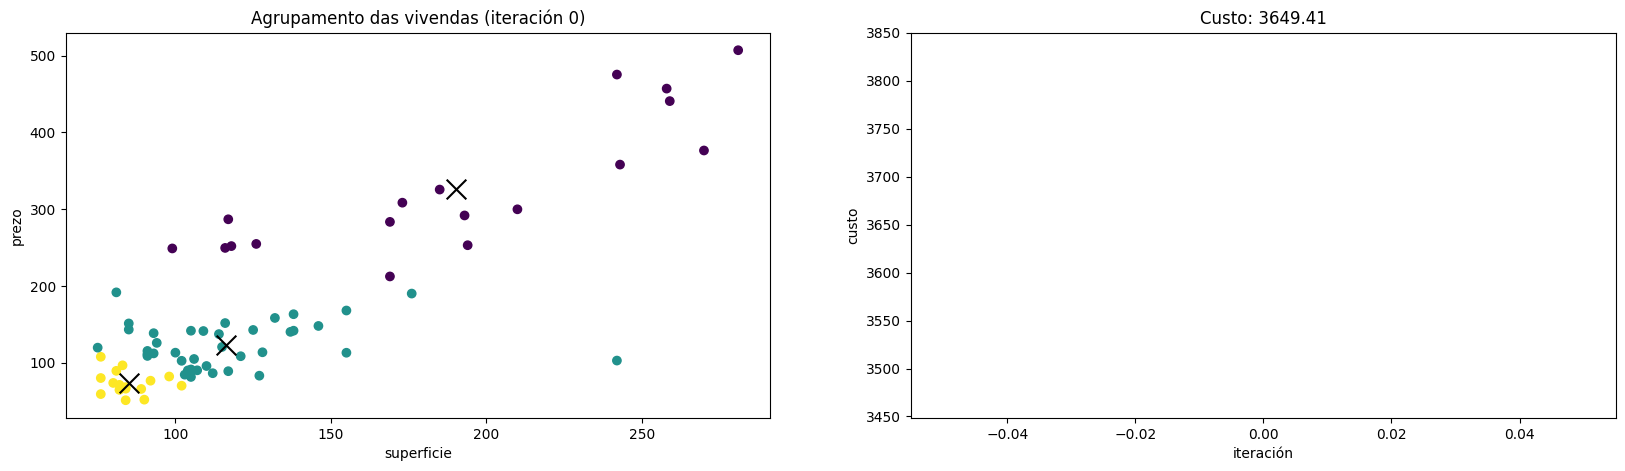

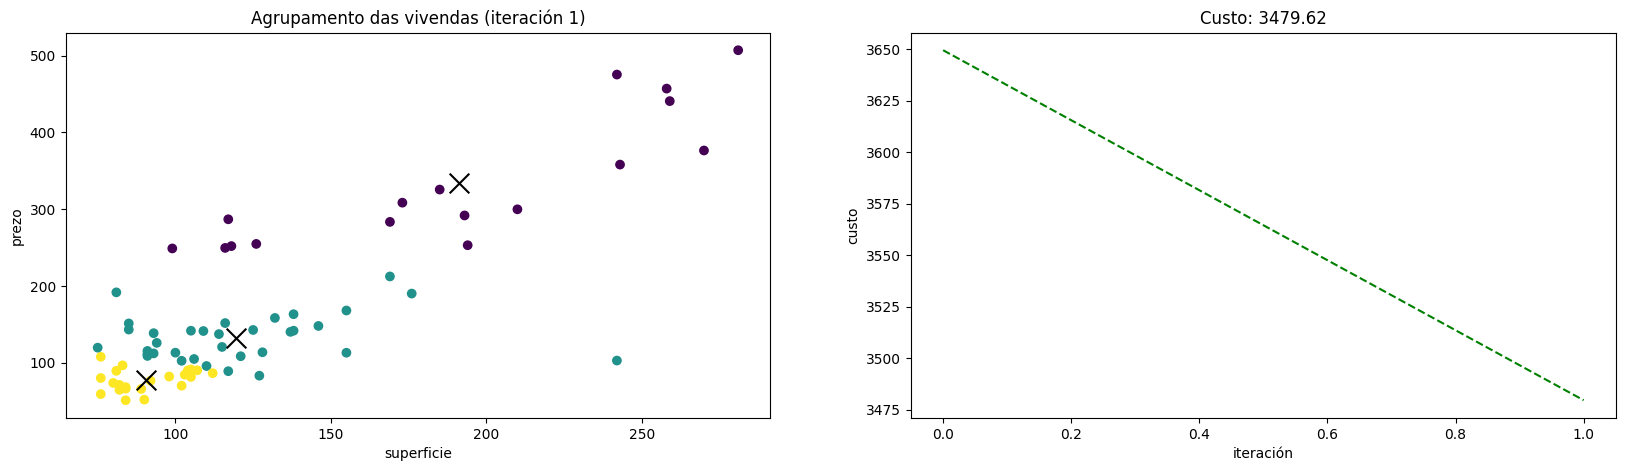

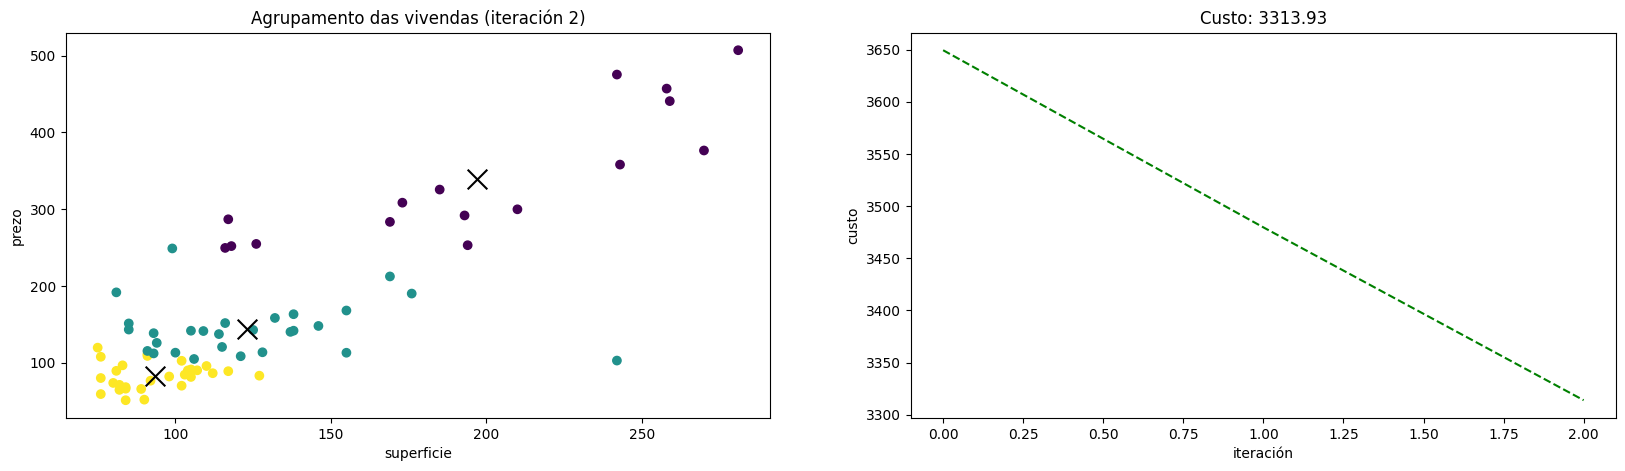

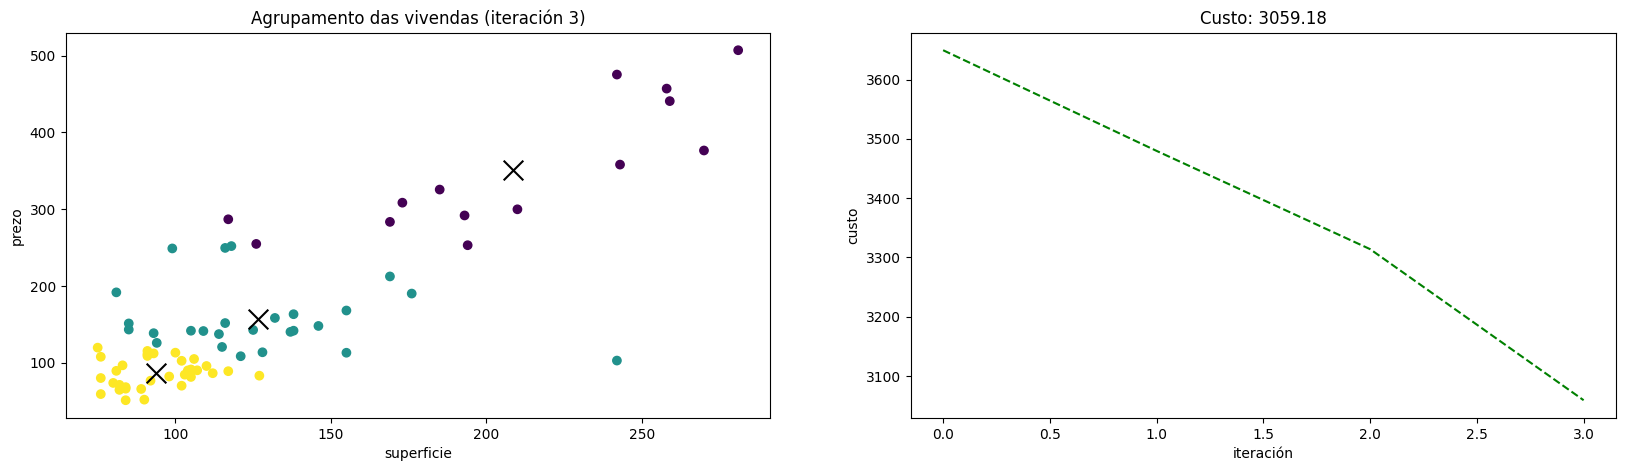

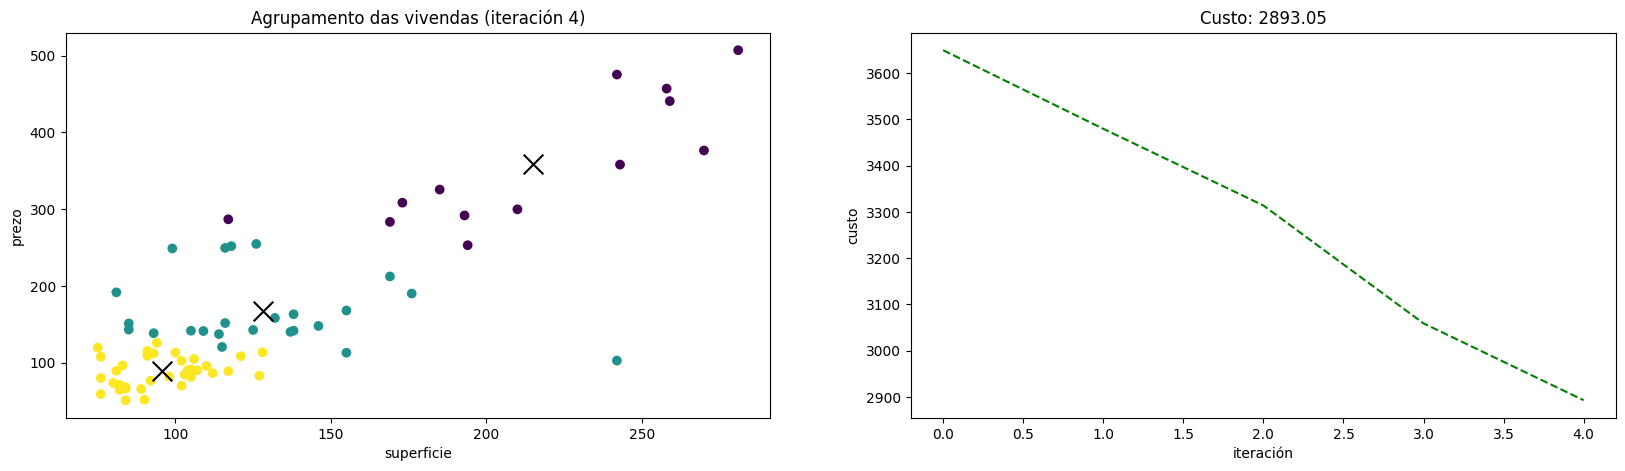

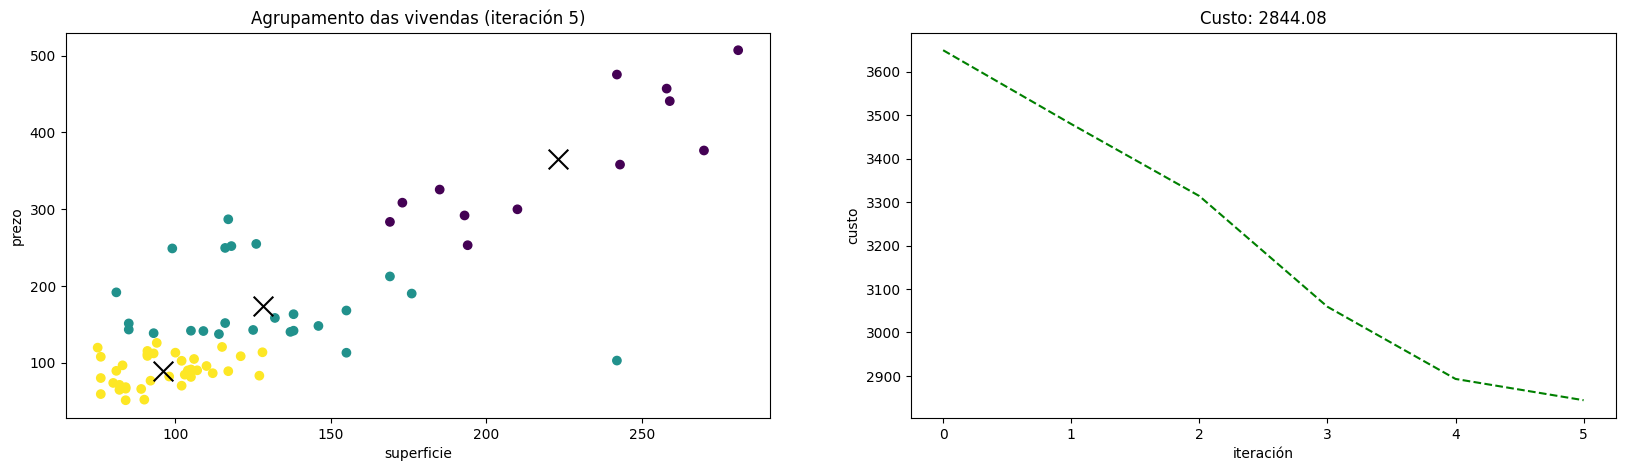

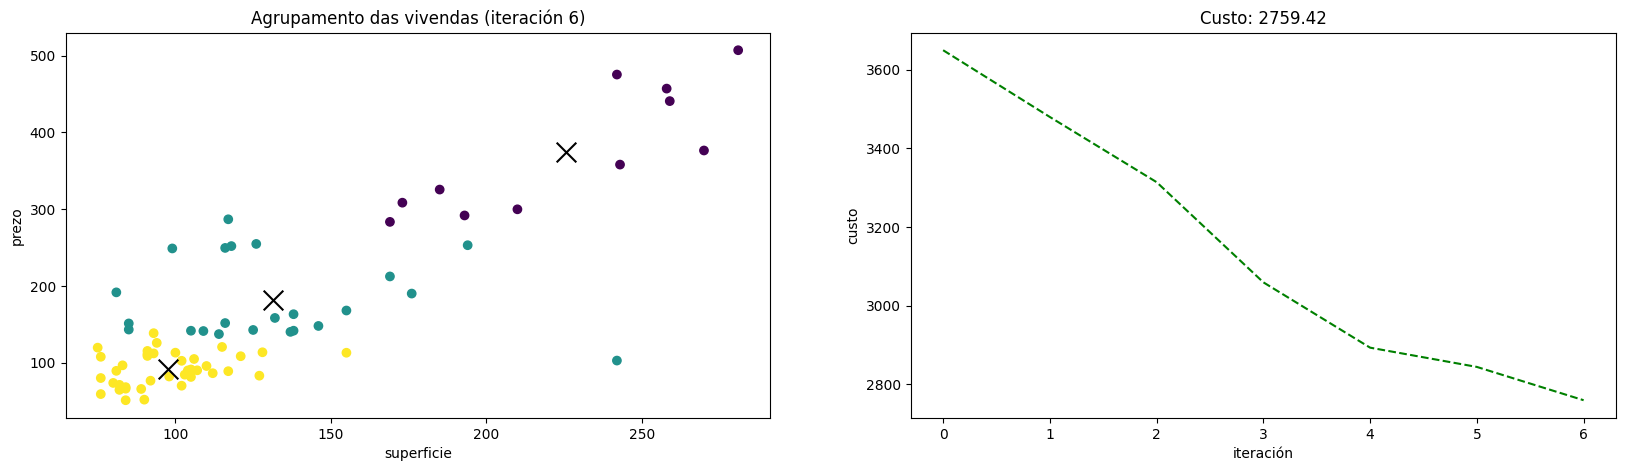

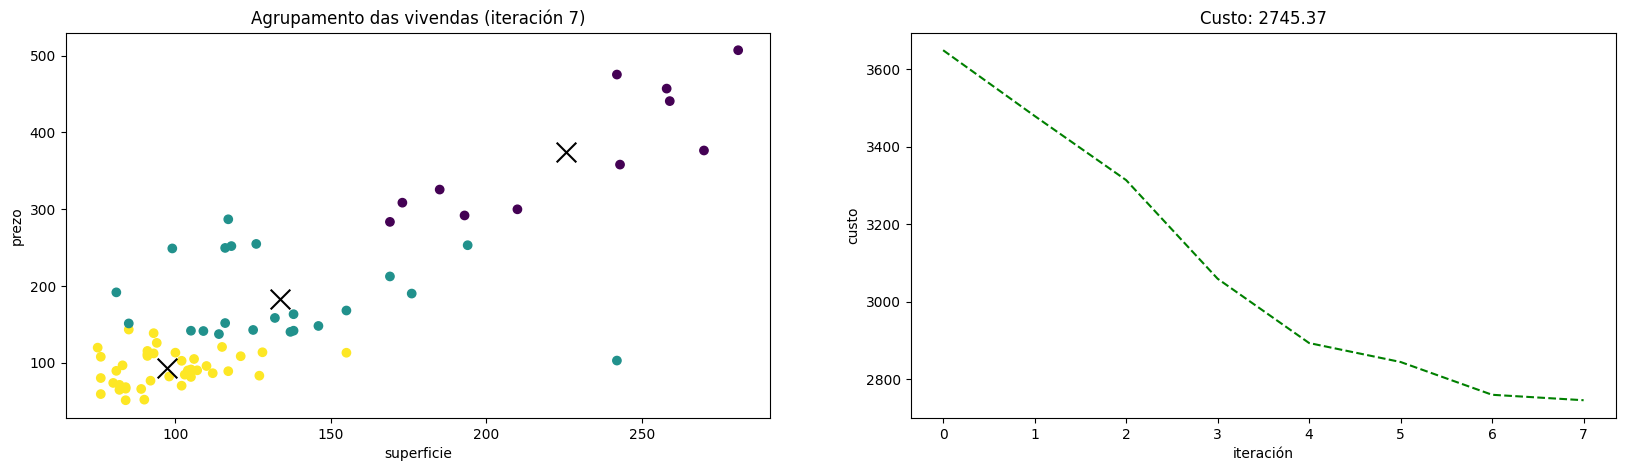

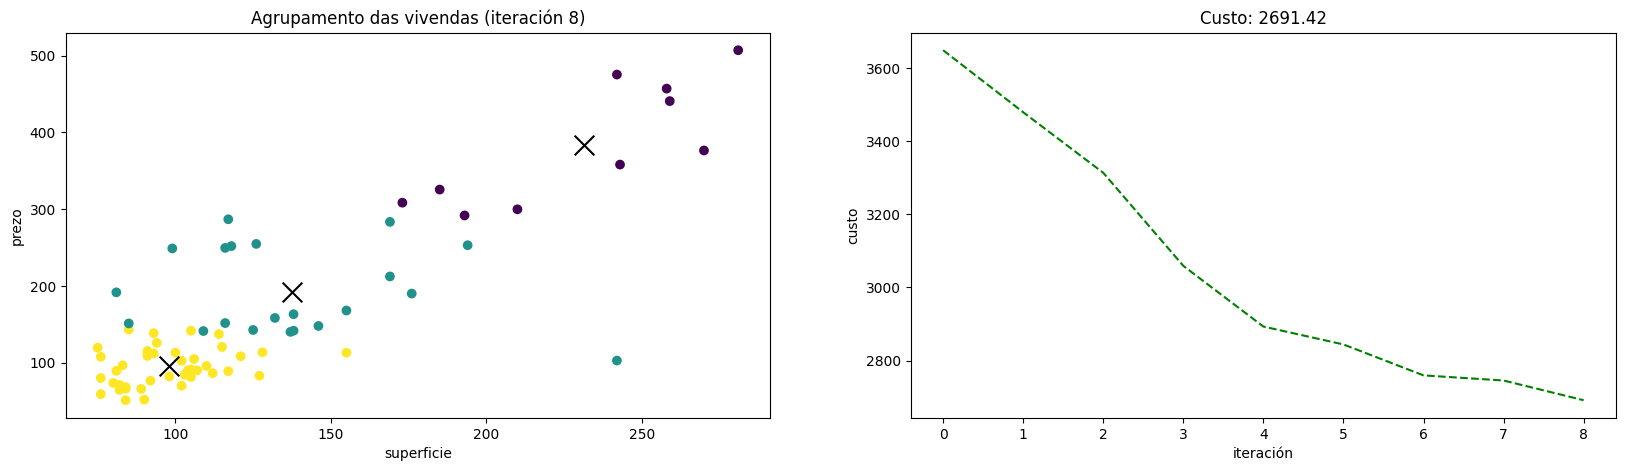

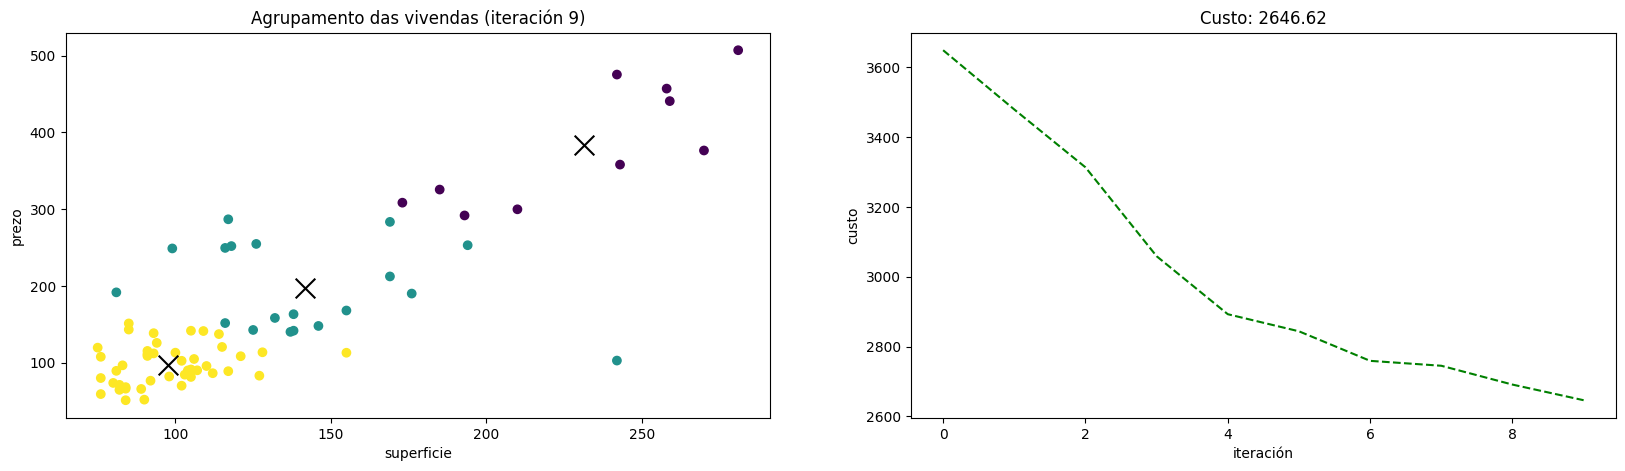

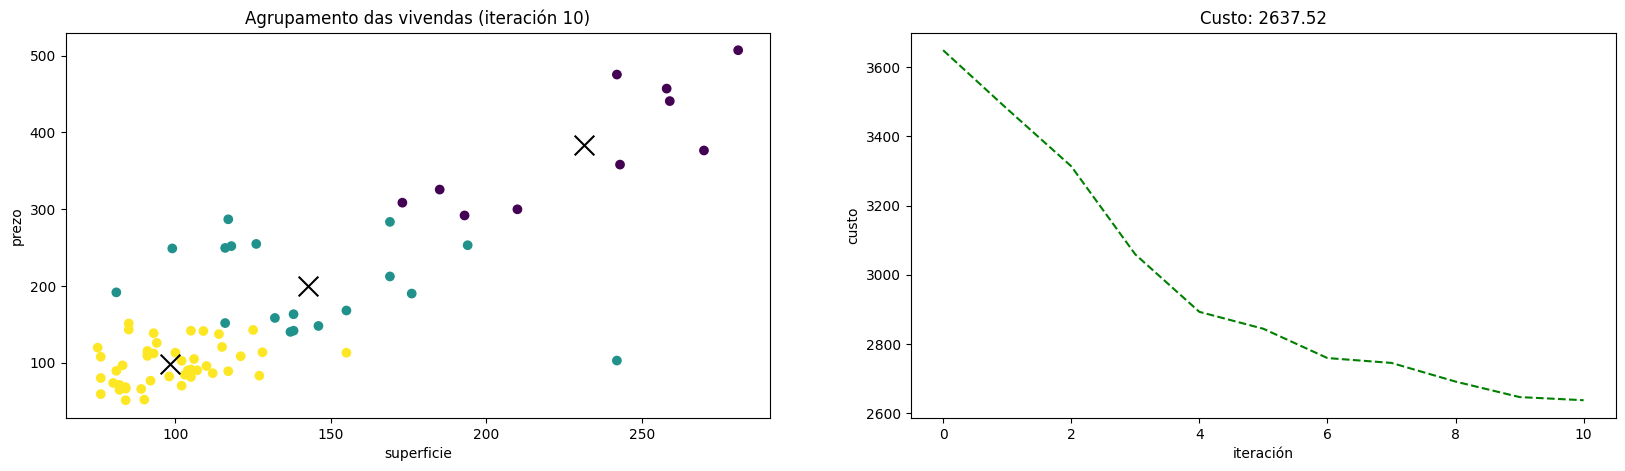

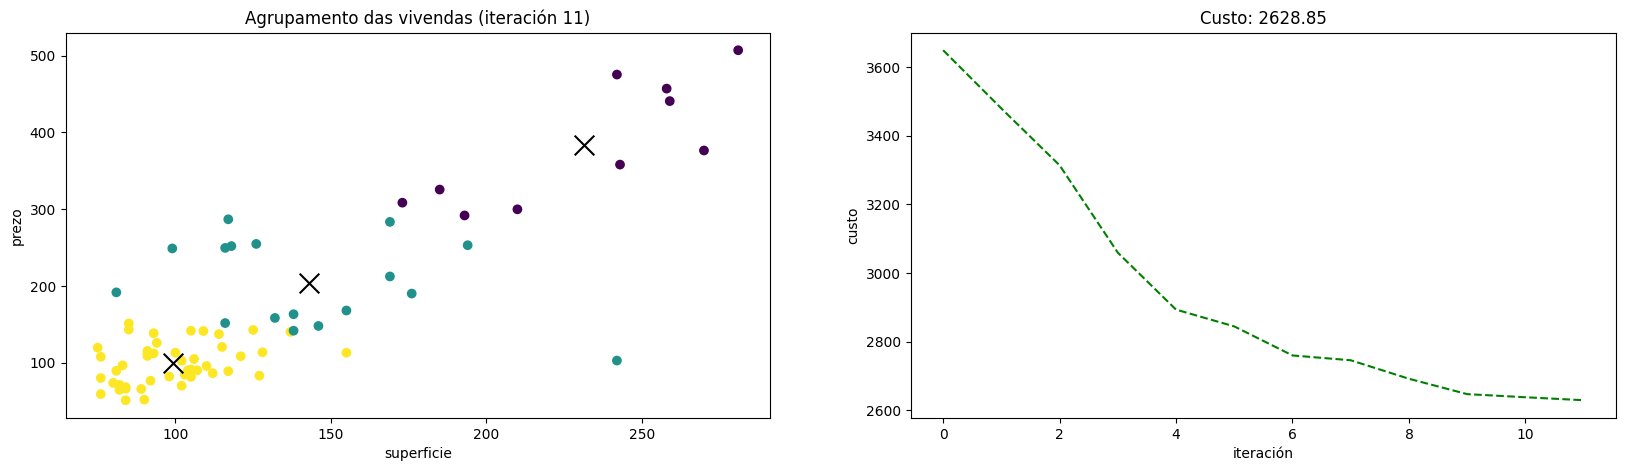

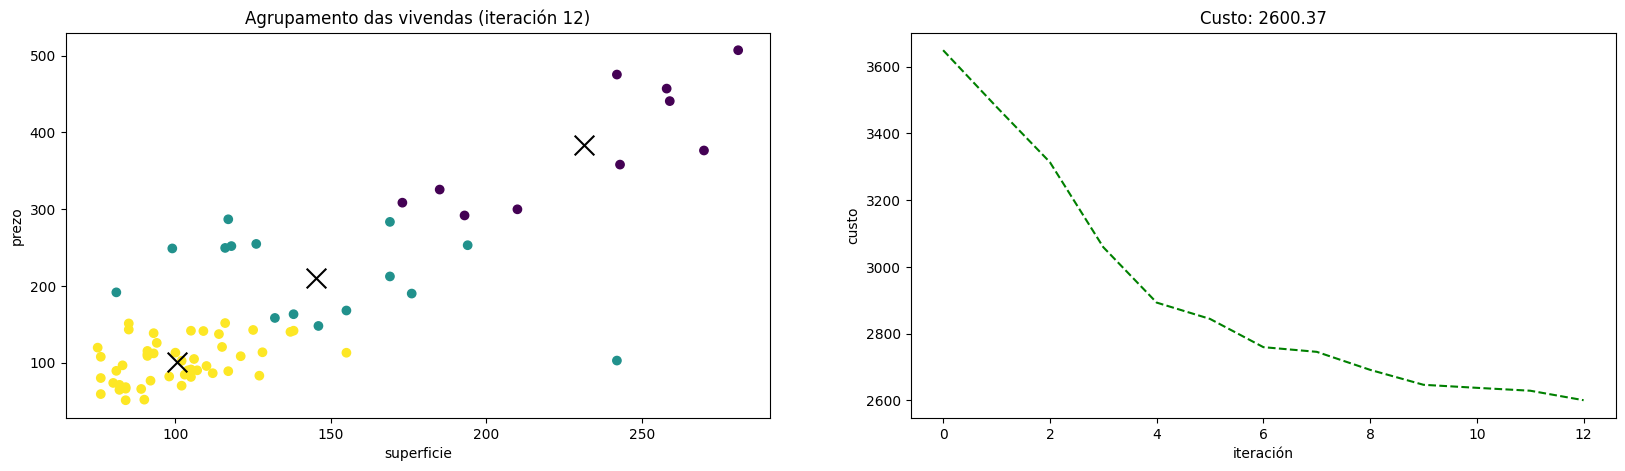

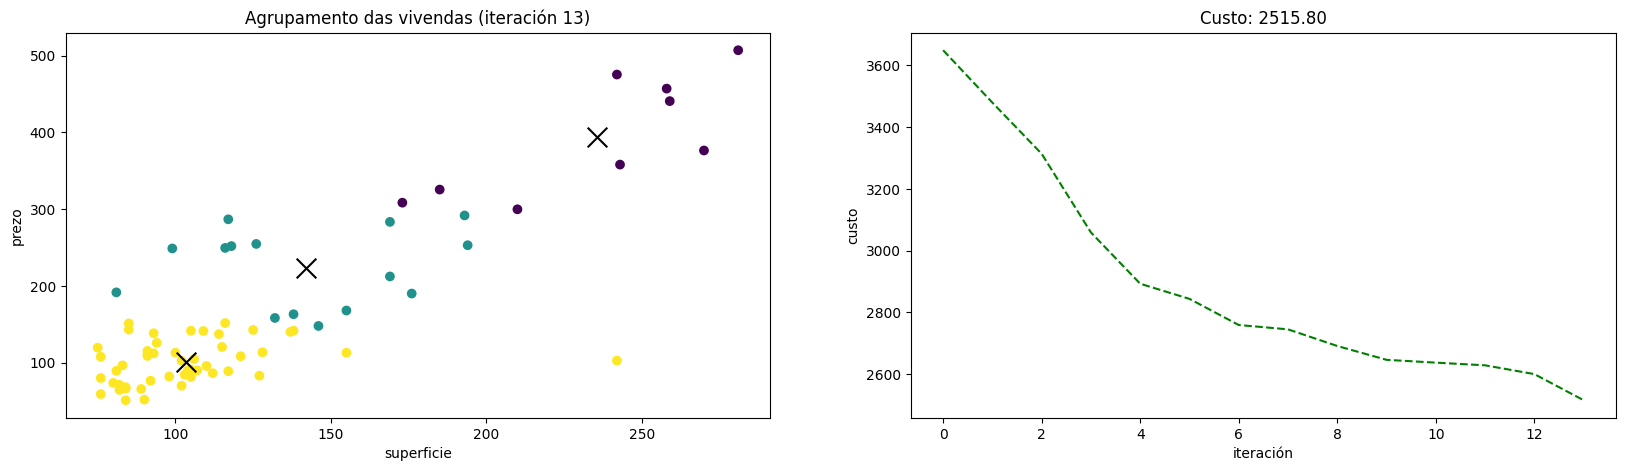

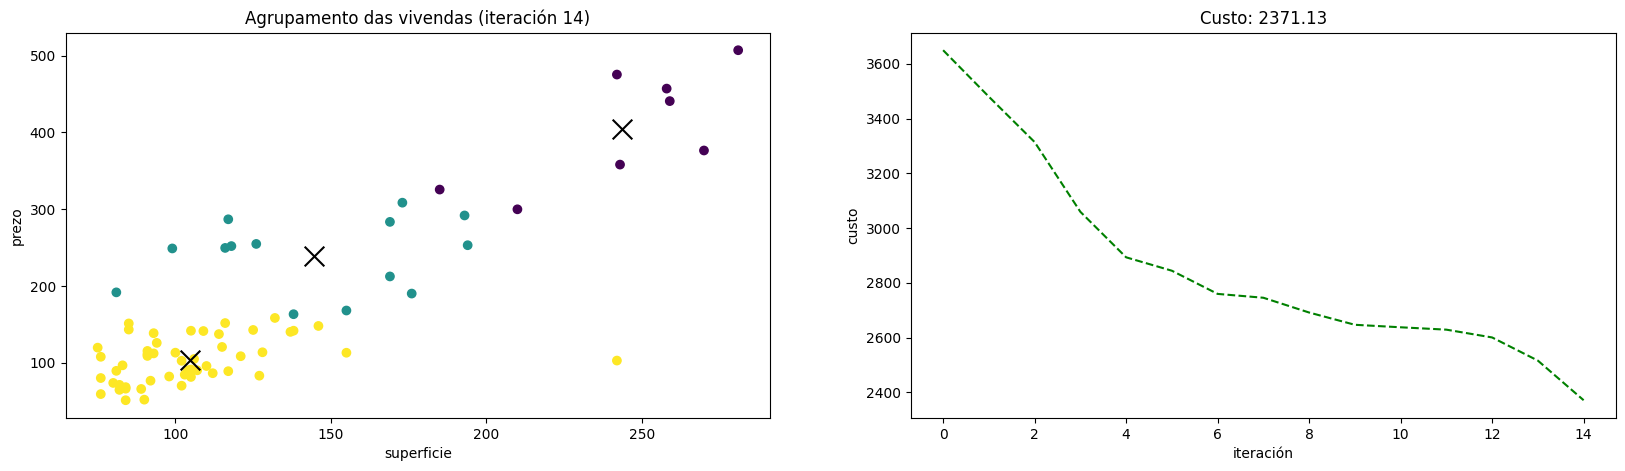

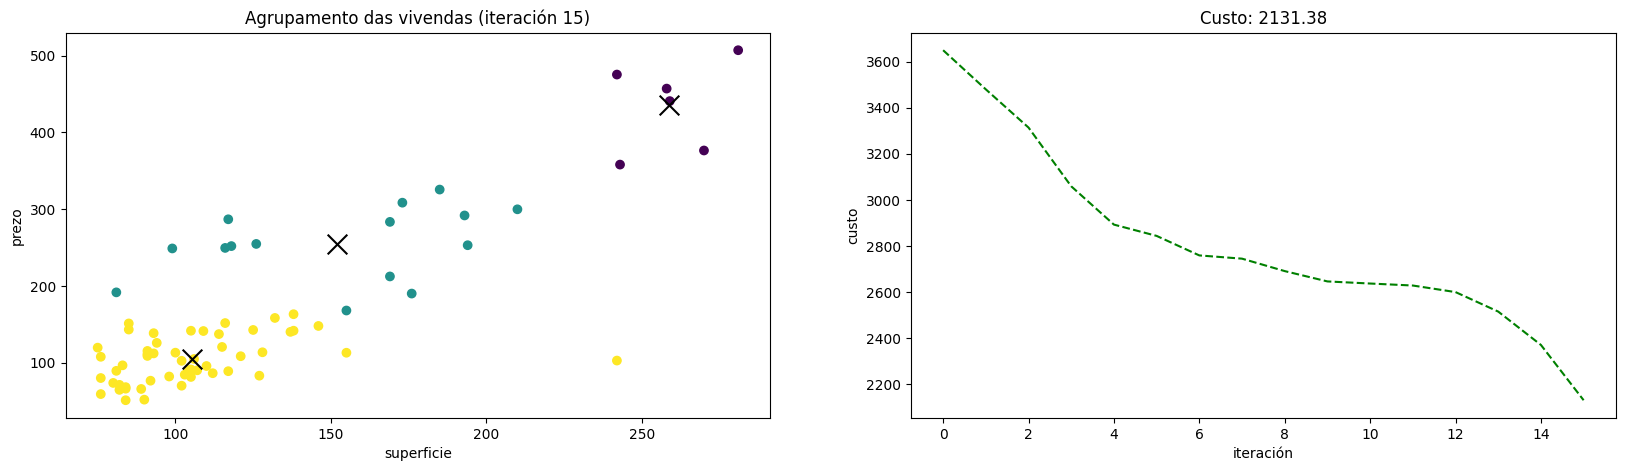

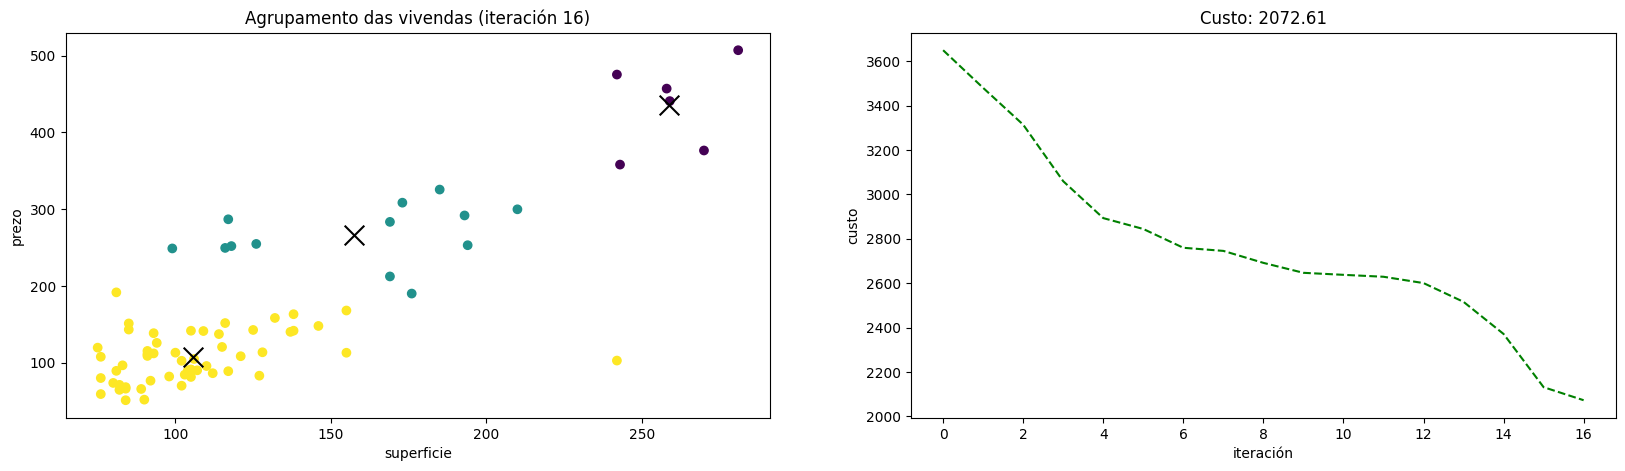

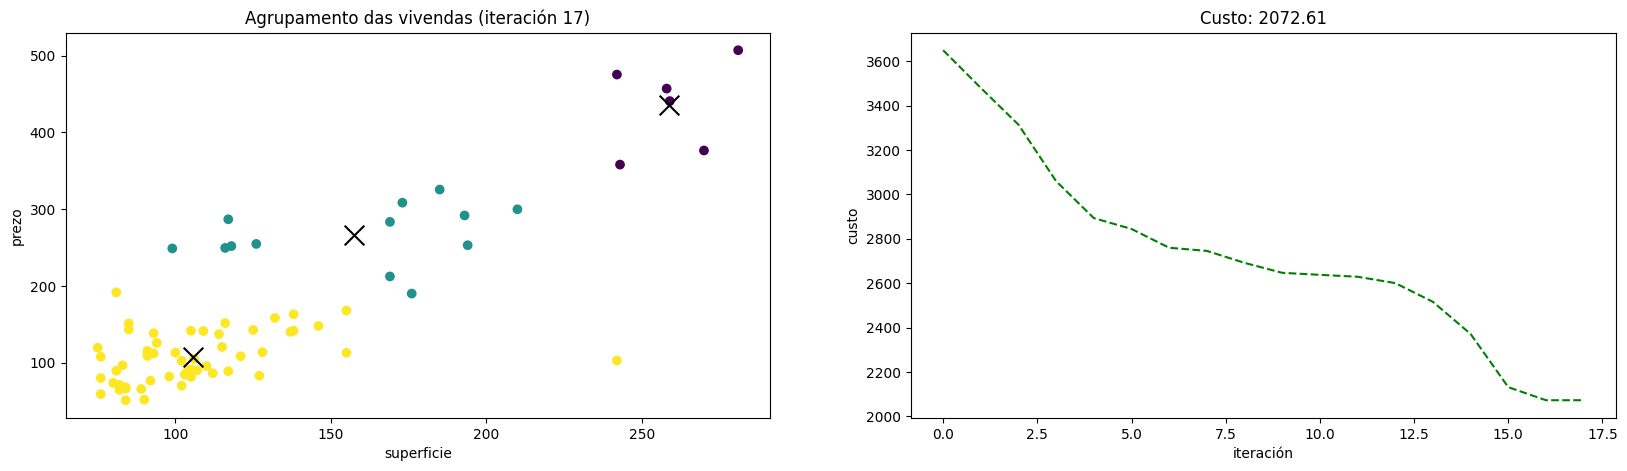

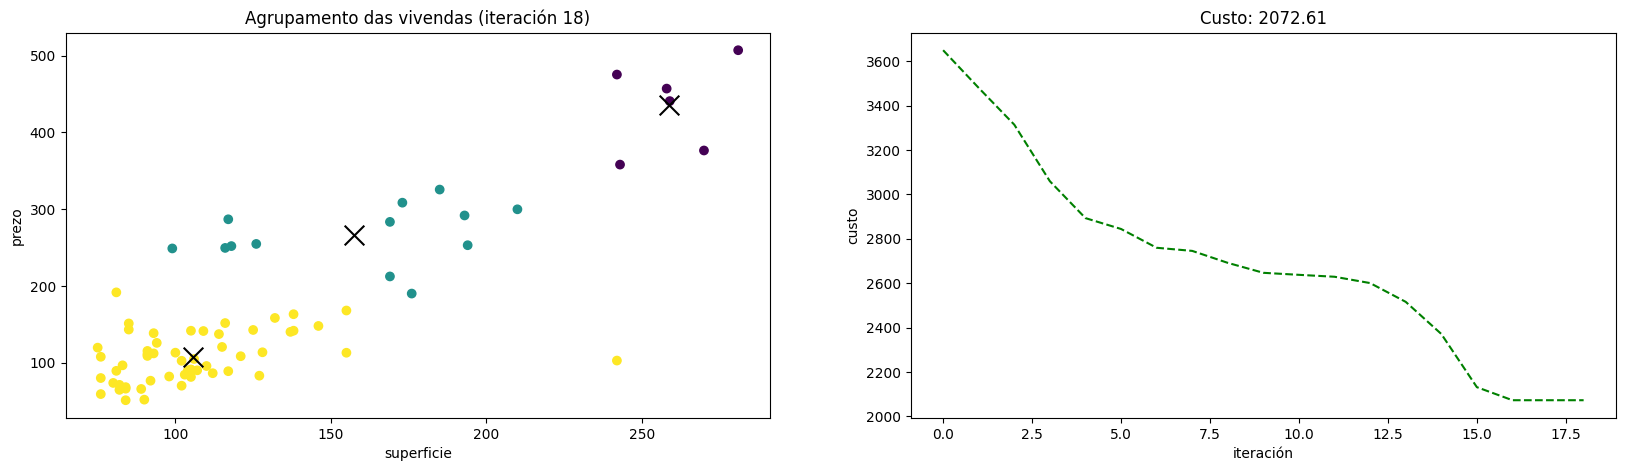

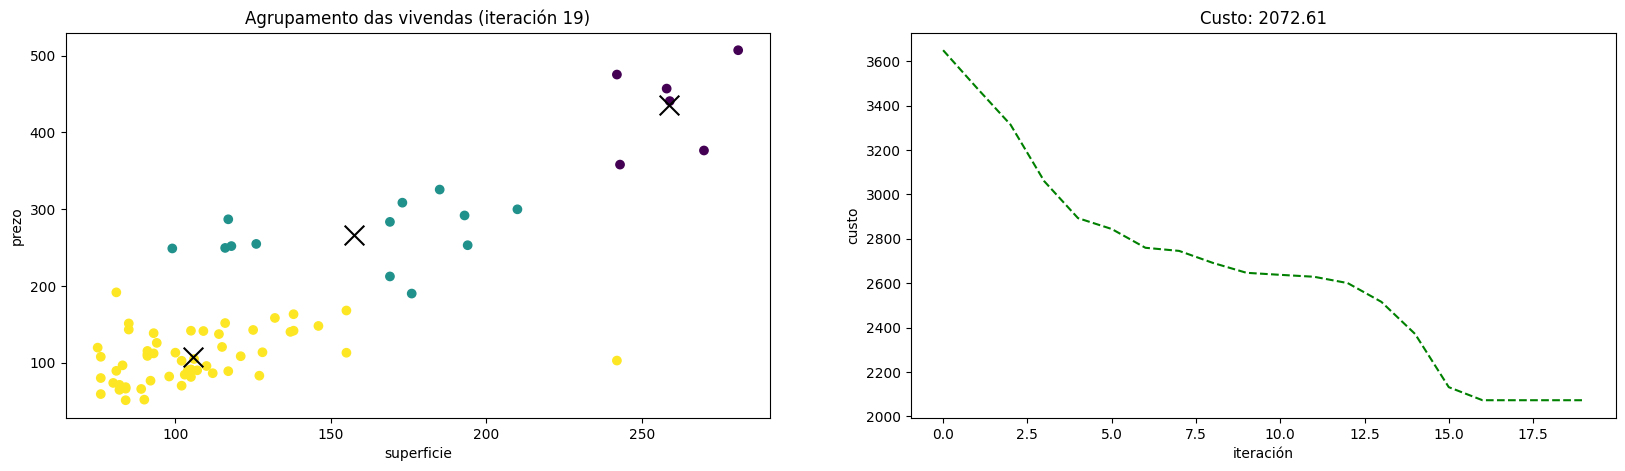

In [10]:
import matplotlib.pyplot as plt

for i in range(n_iter):
    fig = plt.figure(figsize=(20, 5))  # Creamos unha figura (contenedor para elementos a debuxar)
    ax1 = fig.add_subplot(121, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo, queremos unha matrix [1,2])
    ax2 = fig.add_subplot(122, projection='rectilinear')
    
    # Engadimos os scatterplots
    ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=agrupamento_1['clusters'][i])  #Vivendas
    ax1.scatter(agrupamento_1['centroides'][i][:, 0], agrupamento_1['centroides'][i][:, 1],
                s=200, marker='x', color='black')  # Centroides
    ax1.set_title("Agrupamento das vivendas (iteración {})".format(i))  # Poñemos un título
    ax1.set_xlabel("superficie")  # Nombramos os eixos
    ax1.set_ylabel("prezo")
    
    # Engadimos os custos
    ax2.plot(range(i+1), agrupamento_1['custo'][:i+1], '--', color="green")
    ax2.set_title("Custo: {:.2f}".format(agrupamento_1['custo'][i]))  # Poñemos un título
    ax2.set_xlabel("iteración")  # Nombramos os eixos
    ax2.set_ylabel("custo")


    plt.show()  # Mostramos a figura por pantalla

Nas figuras anteriores, a gráfica da esquerda indica sempre o agrupamento realizado. Os exemplos do conxunto de datos coloréanse de distinta cor en función do cluster ao que son asignados. As **x** cunha circunferencia arredor ubican os centroides. Na gráfica da dereita temos a evolución do custo ($J$) nas sucesivas iteracións, tal e como faciamos en regresión lineal.

Agora que viches o proceso de clustering paso a paso, trata de responder ás seguintes cuestións.

> ❓ **_Pregunta 1._**  Lembra que na práctica anterior o custo viña dado polo erro cadrático medio das diferenzas entre cada predición e o valor do prezo real. Como estimamos o custo no caso da aprendizaxe non supervisada con k-means?

> ❓ **_Pregunta 2._**  Explica que é a saída da función `calcula_distancias`.

>❓ **_Pregunta 3._**  Explica que contén `x_cluster_i` e que é o que fai a expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` na función `actualiza_centr`.

> ❓ **_Pregunta 4._**  Identifica no código dos scripts anteriores onde se realizan cada unha das 3 etapas de k-means (inicialización, asignación dos datos aos clusters e actualización dos centroides).

### Inicialización aleatoria múltiple dos centroides

Se cambiamos os centroides iniciais, o algoritmo pode non converxer aos mesmos resultados.

In [11]:
SEED_VALUE = 22634  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados

np.random.seed(SEED_VALUE)
centr_iniciais_2 = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
centr_iniciais_2

array([[259.  , 440.83],
       [ 81.  ,  89.52],
       [126.  , 254.81]])

In [12]:
# Realizamos un novo agrupamento
agrupamento_2 = k_medias(vivendas_mat, centr_iniciais_2, n_iter)

Neste caso, posto que o problema é pequeno e sinxelo, 20 iteracións son máis que suficientes para converxer ao agrupamento óptimo, sexan cales sexan os centroides de arranque:

In [13]:
# Centroides finais do primeiro agrupamento
agrupamento_1['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [14]:
# Centroides finais do segundo agrupamento
agrupamento_2['centroides'][n_iter-1]

array([[258.83333333, 435.845     ],
       [105.77777778, 107.42740741],
       [157.30769231, 265.95846154]])

Fíxate que, aínda que en esencia os resultados son os mesmos que no primeiro agrupamento, os centroides 2 e 3 están intercambiados, polo que tecnicamente a solución á que chega o algoritmo é outra (e, porén, todo o proceso iterativo foi distinto).

En moitos problemas reais os resultados cambiarán moito en función de como inicialicemos os centroides. Incluso no problema das vivendas, se o número de iteracións é máis pequeno (por exemplo, 10), non sempre se acadará o óptimo global. Porén sóense realizar múltiples ($m$) inicializacións aleatorias dos centroides. A seguinte función é unha extensión da función base `k_medias` que permite executar o k-means para $m$ inicializacións distintas dos centroides e un valor $k$ constante:

In [15]:
# Función k-means de inicialización aleatoria múltipe
def k_medias_multi_ini(x, n, m, k):
    x_mat = x.values
    custos_finais = []
    centroides_finais = []
    clusters_finais = []
    for i in range(m):
        centr_iniciais = x_mat[np.random.choice(x_mat.shape[0], size=k, replace=False)]
        agrupamento = k_medias(x_mat, centr_iniciais, n)
        custos_finais.append(agrupamento['custo'][n-1])
        centroides_finais.append(agrupamento['centroides'][n-1])
        clusters_finais.append(agrupamento['clusters'][n-1])
    
    custo_minimo = min(custos_finais)
    indice_mellor = np.argmin(custos_finais)
    centroides_mellor = centroides_finais[indice_mellor]
    clusters_mellor = clusters_finais[indice_mellor]
    
    return {'custo_minimo': custo_minimo, 'mellor_iteracion': indice_mellor,
            'mellores_centroides': centroides_mellor, 'mellor_asignacion': clusters_mellor}

Imos probar a función anterior:

In [16]:
SEED_VALUE = 134  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

m_ini = 10
n_iter = 15
k_cent = 3
agrupamento_3 = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k_cent)

In [17]:
# Mellor iteración
agrupamento_3['mellor_iteracion']

5

In [18]:
# Mellores centroides
agrupamento_3['mellores_centroides']

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [19]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset:
agrupamento_3['mellor_asignacion'][:6]

array([2, 1, 1, 2, 1, 2], dtype=int64)

> ❓ **_Pregunta 5._**  Que devolve a saída da función `k_medias_multi_ini`? Como se elixen os mellores centroides?

In [20]:
agrupamento_3

{'custo_minimo': 2072.6093651192277,
 'mellor_iteracion': 5,
 'mellores_centroides': array([[258.83333333, 435.845     ],
        [157.30769231, 265.95846154],
        [105.77777778, 107.42740741]]),
 'mellor_asignacion': array([2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 1], dtype=int64)}

### Selección do número de centroides

Polo de agora mantivemos o valor de $k$ constante, facendo sempre agrupamentos en 3 clusters. Unha pregunta que che podería xurdir a estas alturas é como saber cal é o número de centroides máis axeitado. A selección do $k$ óptimo é a miúdo ambigua, con interpretacións que dependen da forma e a escala da distribución de puntos no conxunto de datos. Aumentar o $k$ sen penalización sempre reducirá o valor do custo na agrupación resultante, ata o caso extremo de custo cero se cada punto dos datos se considera como o seu propio agrupamento (é decir, cando $k$ é igual ao número de exemplos do conxunto de datos). Intuitivamente, a elección óptima de $k$ acadará un equilibrio entre a compresión máxima dos datos utilizando un só cluster e a máxima precisión ao asignar cada instancia ao seu cluster propio. 

Cando o valor apropiado de $k$ non é evidente a partir do coñecemento previo das propiedades do conxunto de datos, existen métodos que nos axudan a tomar esta decisión. Un dos máis sinxelos é o **método do cóbado** (en inglés, *elbow method*), o cal analiza a redución do custo en función do número de clusters: debe elixirse aquel número de clusters tal que, ao agregar outro cluster máis non se acaden resultados moito mellores. Dun xeito máis formal, se se grafica o custo obtido en función de $k$, os primeiros agrupamentos terán un alto erro por agrupar moitos datos en poucos clusters, pero nalgún momento a ganancia marxinal caerá, provocando un "cóbado" no gráfico. O número de clusters fíxase a este punto, de ahí o nome do método. 

O seguinte script executa o método `k_medias_multi_ini` para distintos valores de $k$ (o mínimo é $k=2$):

In [21]:
SEED_VALUE = 42  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)

k_max = 10
m_ini = 10
n_iter = 20
custos_finais = []
centroides_finais = []
clusters_finais = []
for k in range(2, k_max+1):
    agrupamento = k_medias_multi_ini(x=vivendas, n=n_iter, m=m_ini, k=k)
    custos_finais.append(agrupamento['custo_minimo'])
    centroides_finais.append(agrupamento['mellores_centroides'])
    clusters_finais.append(agrupamento['mellor_asignacion'])

> ❓ **_Pregunta 6._**  Cantas veces se executa o algoritmo k-means no script anterior?

Agora imos aplicar o método do cóbado para determinar o número óptimo de clusters. Para iso, graficamos a evolución do custo en función de $k$:

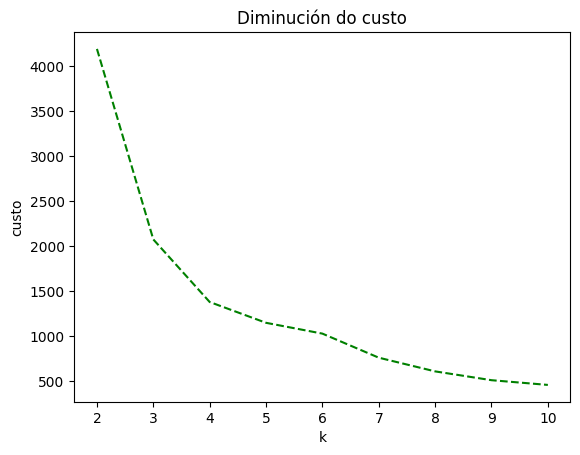

In [22]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=4$. A partir deste valor a mellora que obtemos é moito menos significativa. Por tanto podemos asumir que o número de clusters ideal é 4:

In [23]:
k_mellor = 4

# Centroides para o mellor k (4)
centroides_mellor = centroides_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
centroides_mellor

array([[128.75      , 145.0095    ],
       [ 94.65714286,  88.31571429],
       [155.75      , 272.275     ],
       [258.83333333, 435.845     ]])

In [24]:
# Asignación do mellor cluster para cada un dos 6 primeiros exemplos do dataset
clusters_mellor = clusters_finais[k_mellor-2]  # Hai que ter en conta que a lista comeza en 2
clusters_mellor[:6]

array([0, 2, 2, 0, 2, 1], dtype=int64)

Graficamos o último agrupamento, que imos considerar o definitivo:

<IPython.core.display.Javascript object>


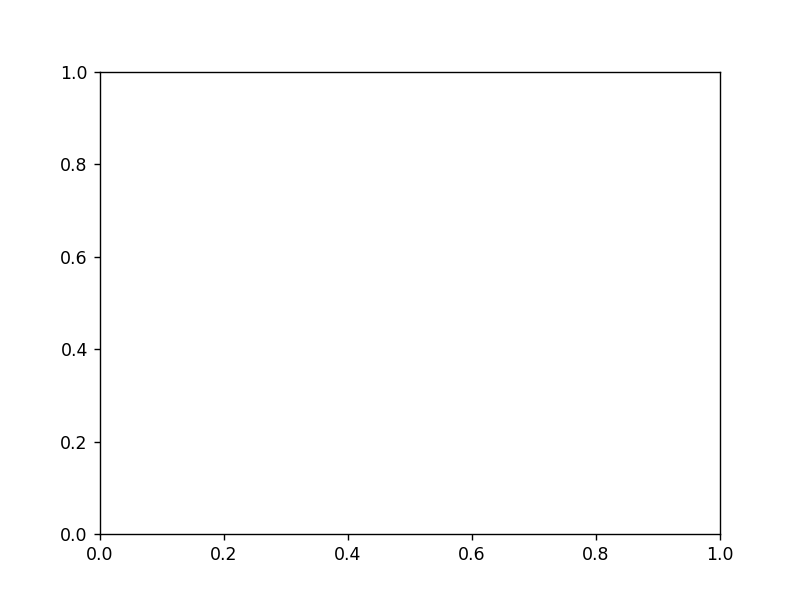

ValueError: 'c' argument has 40 elements, which is inconsistent with 'x' and 'y' with size 73.

In [57]:
fig = plt.figure()  # Creamos unha figura (contenedor para elementos a debuxar)
ax1 = fig.add_subplot(111, projection='rectilinear')  # Engadimos Axes á figura (contén os elementos do debuxo)

# Engadimos os scatterplots
ax1.scatter(vivendas['superficie'], vivendas['prezo'], c=clusters_mellor)  #Vivendas
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', color='black')  # Centroides

ax1.set_title("Agrupamento das vivendas")  # Poñemos un título
ax1.set_xlabel("superficie")  # Nombramos os eixos
ax1.set_ylabel("prezo")

plt.show()  # Mostramos a figura por pantalla

### Interpretación dos resultados

Quedaría agora unha última etapa de análise e interpretación dos resultados. Haberá situacións (coma esta) onde a interpretación sexa bastante trivial. Sen embargo, en moitos problemas reais onde se traballa cun maior número de variables (porén, xa non estamos falando de interpretar un simple gráfico 2D) pode resultar moi complexo lograr atribuírlle un significado aos grupos formados.

> ❓ **_Pregunta 7._**  Fai unha breve interpretación dos clusters obtidos.

## Agrupamento coa función `KMeans`

Unha vez máis, `scikit-learn` facilítanos as tarefas de clustering proporcionándonos paquetes e funcións moi útiles. Unha das funcións imprescindibles é `KMeans`. No seguinte script imos volver a obter o primeiro dos agrupamentos que realizamos no exercicio anterior, pero invocando a `KMeans` en lugar de `k_medias`:

In [26]:
from sklearn.cluster import KMeans

# Definimos o número de iteracións
n_iter <- 20

# Obtemos os mesmos centroides iniciais que antes
SEED_VALUE = 190463  # NON CAMBIES ESTE SEED, así todos teremos os mesmos resultados
np.random.seed(SEED_VALUE)
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]

# Definimos o modelo
model = KMeans(n_clusters=len(centr_iniciais), init=centr_iniciais, n_init=1,
               max_iter=n_iter, algorithm='lloyd', random_state=SEED_VALUE)

# Axustamos o modelo aos datos
np.random.seed(SEED_VALUE)
agrupamento_4 = model.fit(vivendas)

O argumento `algorithm="full"` simplemente nos asegura que por debaixo estamos empregando o mesmo método que o que implementamos no exercicio anterior (hai varias implementacións, podes consultalas na axuda de `scikit-learn`). Vemos que os centroides que obtemos con `KMeans` son os mesmos que obtiñamos antes coa nosa implementación propia:

In [27]:
# Centroides da implementación propia
agrupamento_1['centroides'][-1]

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

In [28]:
# Centroides obtidos coa función KMeans
agrupamento_4.cluster_centers_

array([[258.83333333, 435.845     ],
       [157.30769231, 265.95846154],
       [105.77777778, 107.42740741]])

Bótalle un ollo aos atributos que contén a clase `KMeans`. Observa que entre todos os datos de saída non se inclúe directamente o custo da función $J$ coa que estivemos traballando. Inclúese a suma de todas as distancias, sen facer a media:

In [29]:
# Custo final coa implementación propia
agrupamento_1['custo'][-1]

2072.6093651192277

In [30]:
# Custo final coa función KMeans
agrupamento_4.inertia_ / len(vivendas)

2072.6093651192286

Tamén podemos facer o cálculo manualmente, usando a función $J$ que temos definida:

In [31]:
j(x=vivendas_mat, centroides=agrupamento_4.cluster_centers_, clusters=agrupamento_4.labels_)

2072.6093651192286

**************************************************************

# Respostas ao cuestionario (4 puntos)

**LEMBRA:** Non esquezas de escribir teu nome e apelidos na segunda celda do presente documento.

**Pregunta 1**

 > Neste caso, o custo estímase mediante a media cadrática ao cadrado, é dicir, distancia ao cadrado media dos puntos ao centroide asignado elevada ao cadrado:
 > <center>
 > $x_{rms} = \frac{1}{N}\sum_{i=1}^{N}{x_{i}^{2}}$ </center>

**Pregunta 2**



> A saída da funcion `calcula_distancias` é un array bidimensional de numpy, é dicir, unha matriz. Esta matriz ten tantas filas como elementos ten o vector *a* e tantas columnas como elementos ten o vector *b*.
>
> A matriz almacena a distancia entre os elementos de *a* e os de *b*, de forma que o elemento *(i,j)* da matriz almacena a distancia entre o elemento *i* de *a* e o elemento *j* de *b*.

**Pregunta 3**



> `x_cluster_i` é un matriz que contén os puntos que, en cada iteración da función `k_medias`, se asocian ao centroide *i*. Cada fila da matriz é un punto, mentres que as columnas son as coordenadas deste punto en $R^2$ (No exemplo das vivendas, a primeira compoñente correspóndese coa superficie e a segunda, co prezo). 
>
> A expresión `np.sum(x_cluster_i, axis=0)/x_cluster_i.shape[0]` suma todos os puntos almacenados en `x_cluster_i`, tratándoos como puntos de $R^2$. O punto obtido divídeo entre *N* (divídese cada unha das compoñentes entre *N*).
> O parámetro `axis=0`, indícalle á función *sum* do paquete *numpy*, que debe sumar os elementos da matriz por filas, sumando cada unha das compoñentes de cada punto.

**Pregunta 4**



> En primeiro lugar, a inicialización realízase fóra da función `k_means`, mediante a seguinte liña:
>
~~~
centr_iniciais = vivendas_mat[np.random.choice(vivendas_mat.shape[0], size=3, replace=False)]
~~~
> Deste xeito, xéranse 3 valores aleatoriamente entre 0 e o número de vivendas (obtido con `vivendas_mat.shape[0]`) mediante a función `np.random.choice`. O centroides iniciais, serán os puntos do vector *x* cuxo índice sexa algúns destes tres números obtidos aleatoriamente.
>
> Por outro lado, a etapa de asignación lévase a cabo na función `k_means` mediante as seguintes liñas:
>
~~~
dist_centroides = calcula_distancias(x, centroides)
clusters = np.argmin(dist_centroides, axis=1) 
~~~
>
> Para cada fila da matriz de distancias almacenada en `dist_centroides`, mediante a función `argmin` calcúlase o mínimo e devólvese o índice do mínimo. Este índice correspóndese co centroide máis próximo ao punto.
>
> Por último, a actualización dos centroides lévase a cabo mediante a chamada á función `actualiza_centr`.
>
~~~
centroides = actualiza_centr(x, clusters, centroides)
~~~

**Pregunta 5**



> Devolve un dicionario con 4 elementos. 
> - O primeiro, almacena o custo da iteración que alcanzou unha configuración final dos centroides co menor custo.
> - O segundo, almacena a iteración que alcanzou unha configuración final dos centroides co menor custo.
> - O terceiro, almacena a configuración final dos centroides co menor custo.
> - O cuarto, a asiganción dos puntos aos centroides da configuración co menor custo.
>
> Os mellores centroides escóllense mediante o custo. Para iso, calcúlase o mínimo da lista `custos_finais`, que almacena os custos despois das 20 iteracións de cada inicialización aleatoria dos centroides. Os mellores centroides correspóndese coa iteración na que se obtivo a configuración dos centroides que produciu o custo mínimo.

**Pregunta 6**



> A función `k_medias` execútase $m$ veces cada vez que se chama á función `k_medias_multi_ini`. Deste xeito, como dende o script anterior se chama $k_max - 1$ veces á función `k_medias_multi_ini`, entón, estase executando $(k\_max - 1)\cdot m$ veces a función `k_medias` no script anterior.
>
> Se $m = 10$ e $k\_max = 10$, o algoritmo k-means estase executando 90 veces.

**Pregunta 7**



> Os datos divídense en 4 clusters:
>
> - Clúster asociado ao centroide (94.65714286 , 88.31571429): Este clúster podería incluír as vivendas de peor calidade dentro do conxunto de datos. Isto pode ser así, xa que as vivendas asociadas a este clúster custan, case todas, menos de 100.000 €. Por outra banda, as vivendas que pertencen a este clúster que superan os 100.000 €, non teñen máis de 100 metros cadrados, polo que poderíamos pensar que, a pesar de tratarse de vivendas de máis calidade (quizais son máis céntricas ou teñen algunha característica positiva que as diferencia un pouco do resto de vivendas deste clúster) seguen sendo relativamente pequenas.
>
>    De forma resumida, este clúster podería interpretarse como pisos céntricos ou próximos a unha cidade relativamente pequenos e sen un coidado especial.
>
>
> - Clúster asociado ao centroide (128.75      , 145.0095   ): Este clúster agrupa vivendas de superficies moi diversas. Non obstante, o prezo de todas elas non varía moito e mantense entre os 100.000 e os 200.000 euros. Isto último xunto coa variabilidade da superficie deste clúster podería indicar que este clúster inclúe pisos grandes, posiblemente con varios andares, e casas pequenas. Estas últimas poderían ser casas situadas nas aforas dunha cidade e non moi luxosas.
>
>
> - Clúster asociado ao centroide (155.75      , 272.275    ): Este clúster sitúase nun rango de prezos superior ao anterior clúster, entre os 200.000 € e os 300.000 €. Non obstante, agora as vivendas teñen superficies máis dispersas. Isto xunto que a superficie mínima deste clúster está nos 100 metros cadrados, poderíamos pensar que se trata de casas grandes que pertencen a urbanizacións. Normalmente, as urbanizacións de casas constan con piscinas e espacios comúns grandes que poderían xustificar os prezos elevados. Tamén podería ser que entrase neste clúster algún piso bastante grande con varios andares, xa que algunhas vivendas deste clúster non pasan dos 120 metros cadrados.
>
>
> - Clúster asociado ao centroide (258.83333333, 435.845   ): Por último, este clúster podería agrupar aquelas casas bastante grandes e caras. Podería tratarse de chalets luxosos (aínda que non millonarios) como de casas de urbanizacións moi boas.
>
> Tendo en conta os comentarios anteriores e a gráfica, observamos que podemos interpretar os clústers en función do nivel económico da persoa que vai vivir alí. Deste xeito, o máis baixo corresponderíase cun nivel de vivendas adecuadas para un nivel adquisitivo medio; o segundo, corresponderíase cun nivel adquisitivo medio-alto; o terceiro, cun nivel alto; e, por último, o cuarto corresponderíase con aquelas persoas que teñen un nivel adquisitivo moi alto.

**************************************************************

# Modelado dun problema de libre elección 

## Enunciado

Pon en práctica os teus coñecementos de aprendizaxe non supervisado e intenta agora ti buscar relacións entre os datos dun problema que se che ocorra. Nos exercicios anteriores abordouse o caso de 2 variables, polo que animámoste agora a que trates de aplicar clustering sobre un problema con máis dimensións. O único requerimento obrigatorio é **empregar máis de dúas variables para o clustering**. Ten en conta que a nosa implementación de k-means (`k_medias`) está pensada para funcionar sobre conxuntos de datos con dúas variables, pero non é escalable a máis dimensións (certo é que as modificacións necesarias para logralo son mínimas). A vantaxe da función `KMeans` propia de `scikit-learn` é a súa flexibilidade, pois o seu parámetro `x` pode tomar como entrada conxuntos de datos cun maior número de variables. Ten tamén presente que ao aplicar clustering sobre un conxunto de datos de máis de 2 ou 3 variables, a súa visualización complícase e o mellor é visualizar o agrupamento por pares de variables de cara a obter unha boa interpretación.

Igual que na práctica anterior, podes recadar datos e construir un pequeno dataset ti mesmo ou ben obter un de Internet. Fai un breve estudo dos teus datos, incluíndo gráficas e comentarios propios. Obtén un bo agrupamento e da unha interpretación do mesmo. Proporciona todo o código que consideres necesario empregando scripts como os dos exercicios anteriores. Ao entregar esta práctica deberás incluir tamén o arquivo cos datos do teu problema no formato que che resulte máis cómodo (.csv, .txt, etc.).

**************************************************************

## Resposta (6 puntos)

### Selección do dataset e análise dos datos

No meu caso, reutilizarei o dataset da práctica anterior, que contén os puntos por partido, asistencias por partido, rebotes por partido, altura e salario medio anual dos 40 xogadores da NBA mellor pagados nesta tempada 2022/2023.

In [32]:
import pandas as pd  # Importamos a librería (isto sólo é necesario facelo unha vez)

xogadores = pd.read_csv('xogadores.csv',  # Cargamos o csv
                       delimiter=',',
                       header=0)

xogadores.head()

,xogador,mediapuntos,mediarebotes,mediaasistencias,altura,averageannualvalue
0,Stephen Curry,31.4,6.7,7.3,1.88,53838.416
1,LeBron James,25.8,8.6,6.3,2.06,42827.766
2,Russell Westbrook,16.0,5.2,7.2,2.03,41358.814
3,Bradley Beal,26.6,3.8,6.6,1.93,50203.930
4,Kevin Durant,30.4,6.5,7.3,2.08,41063.925


En primeiro lugar, debemos decidir cantas variables empregaremos no estudo. Na anterior práctica, tratei de predicir o salario medio anual a partir das asistencias e dos puntos, pois eran as variables que máis correlación tiñan co salario. Non obstante, agora podería ser interesante incluír as 5 variables e tratar de clasificar aos xogadores empregando todas as variables do conxunto de datos.

Con todo, haberá que comprobar se todas as variables son útiles para clasificar aos xogadores. Pode darse o caso de que a mellor forma de agrupar os datos non empregue todas as variables do dataset.

### Visualización dos datos

Antes de agrupar os datos, tratamos de visualizalos en gráficos de dúas dimensións, nos que temos en conta cada par de variables.

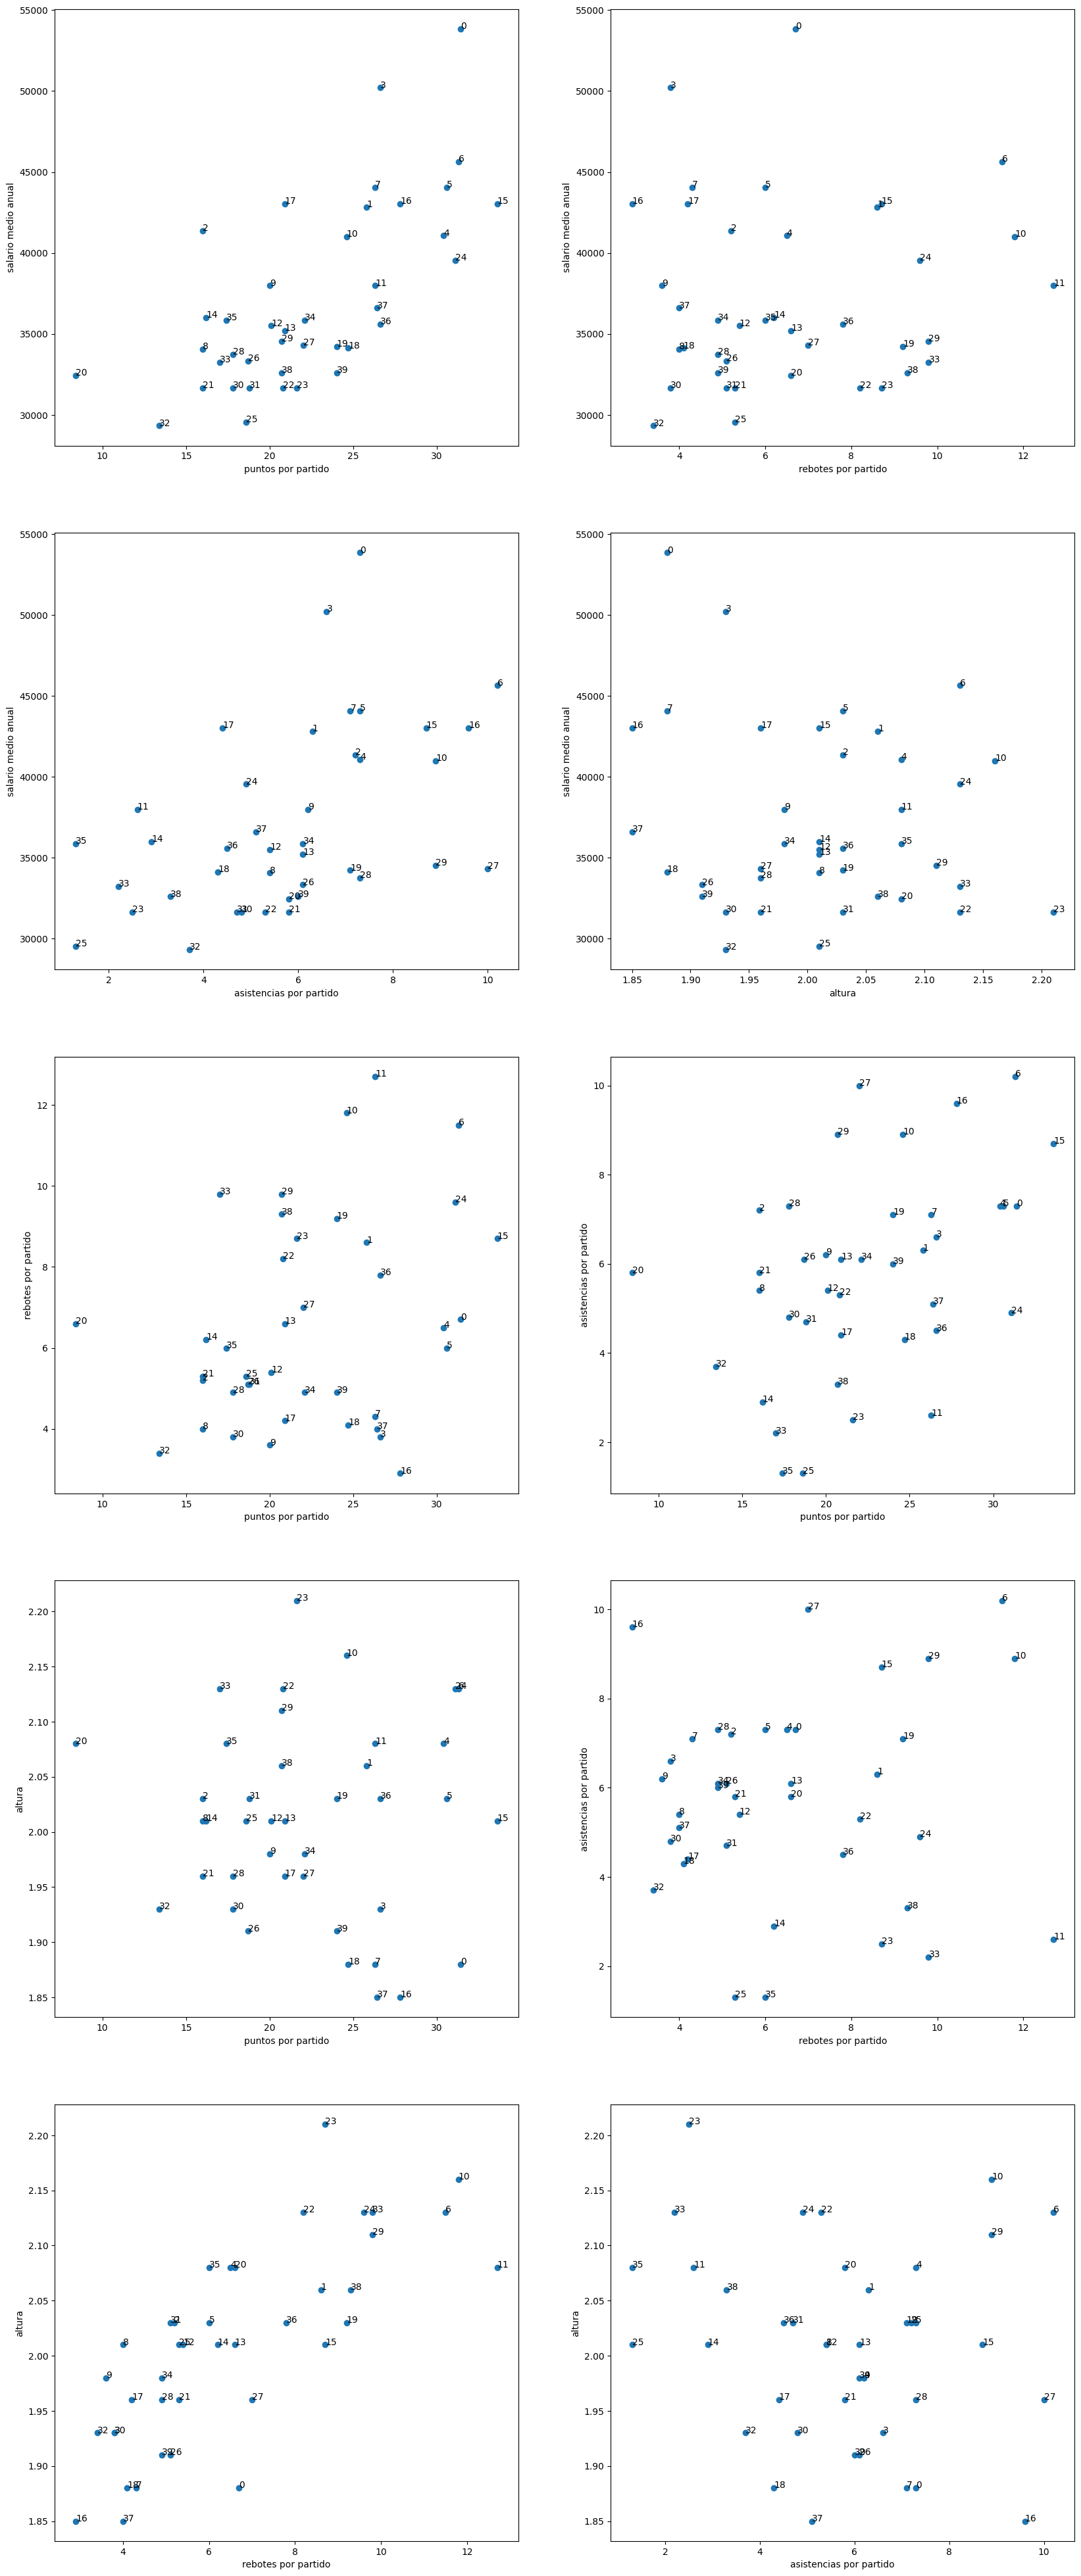

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Creamos o entorno
fig = plt.figure(figsize=(20, 50))
ax1 = fig.add_subplot(521, projection='rectilinear') 
ax2 = fig.add_subplot(522, projection='rectilinear')
ax3 = fig.add_subplot(523, projection='rectilinear') 
ax4 = fig.add_subplot(524, projection='rectilinear')
ax5 = fig.add_subplot(525, projection='rectilinear') 
ax6 = fig.add_subplot(526, projection='rectilinear')
ax7 = fig.add_subplot(527, projection='rectilinear') 
ax8 = fig.add_subplot(528, projection='rectilinear')
ax9 = fig.add_subplot(529, projection='rectilinear')
ax10 = fig.add_subplot(5,2,10, projection='rectilinear')

# Nomeamos os eixos
ax1.set_xlabel("puntos por partido")
ax1.set_ylabel("salario medio anual")

ax2.set_xlabel("rebotes por partido")
ax2.set_ylabel("salario medio anual")

ax3.set_xlabel("asistencias por partido")
ax3.set_ylabel("salario medio anual")

ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

ax5.set_xlabel("puntos por partido")
ax5.set_ylabel("rebotes por partido")

ax6.set_xlabel("puntos por partido")
ax6.set_ylabel("asistencias por partido")

ax7.set_xlabel("puntos por partido")
ax7.set_ylabel("altura")

ax8.set_xlabel("rebotes por partido")
ax8.set_ylabel("asistencias por partido")

ax9.set_xlabel("rebotes por partido")
ax9.set_ylabel("altura")

ax10.set_xlabel("asistencias por partido")
ax10.set_ylabel("altura")

# Debuxamos o scatter
ax1.scatter(xogadores['mediapuntos'], xogadores['averageannualvalue'])
ax2.scatter(xogadores['mediarebotes'], xogadores['averageannualvalue'])
ax3.scatter(xogadores['mediaasistencias'], xogadores['averageannualvalue'])
ax4.scatter(xogadores['altura'], xogadores['averageannualvalue'])
ax5.scatter(xogadores['mediapuntos'], xogadores['mediarebotes'])
ax6.scatter(xogadores['mediapuntos'], xogadores['mediaasistencias'])
ax7.scatter(xogadores['mediapuntos'], xogadores['altura'])
ax8.scatter(xogadores['mediarebotes'], xogadores['mediaasistencias'])
ax9.scatter(xogadores['mediarebotes'], xogadores['altura'])
ax10.scatter(xogadores['mediaasistencias'], xogadores['altura'])

# Imprimimos os identificadores
for i in xogadores.index:
    ax1.text(xogadores.loc[i,'mediapuntos'], xogadores.loc[i,'averageannualvalue'], i)
    ax2.text(xogadores.loc[i,'mediarebotes'], xogadores.loc[i,'averageannualvalue'], i)
    ax3.text(xogadores.loc[i,'mediaasistencias'], xogadores.loc[i,'averageannualvalue'], i)
    ax4.text(xogadores.loc[i,'altura'], xogadores.loc[i,'averageannualvalue'], i)
    ax5.text(xogadores.loc[i,'mediapuntos'], xogadores.loc[i,'mediarebotes'], i)
    ax6.text(xogadores.loc[i,'mediapuntos'], xogadores.loc[i,'mediaasistencias'], i)
    ax7.text(xogadores.loc[i,'mediapuntos'], xogadores.loc[i,'altura'], i)
    ax8.text(xogadores.loc[i,'mediarebotes'], xogadores.loc[i,'mediaasistencias'], i)
    ax9.text(xogadores.loc[i,'mediarebotes'], xogadores.loc[i,'altura'], i)
    ax10.text(xogadores.loc[i,'mediaasistencias'], xogadores.loc[i,'altura'], i)

plt.show()

Debemos ter en conta que as distancias que se aprecian en cada figura poden ser moi diferentes ás reais, debido a que estas gráficas son proxeccións dos puntos nun plano en dúas dimensións. Os puntos orixinais poderíamos representalos en $R^5$ (cada dimensión representaría unha variable do dataset), co que pode que dous puntos parezan próximos posto que, con respecto a dúas variables toman valores próximos, mais con respecto a outra estean moi lonxe.

Por exemplo, os xogadores número 22 e 24.

In [34]:
xogadores.loc[[22,24], :]

,xogador,mediapuntos,mediarebotes,mediaasistencias,altura,averageannualvalue
22,Karl-Anthony Towns,20.8,8.2,5.3,2.13,31650.60
24,Joel Embiid,31.1,9.6,4.9,2.13,39542.01


Con respecto á altura e ás asistencias poderíamos dicir que están preto, mais con respecto aos puntos por partido e ao salario medio anual están considerablemente lonxe.

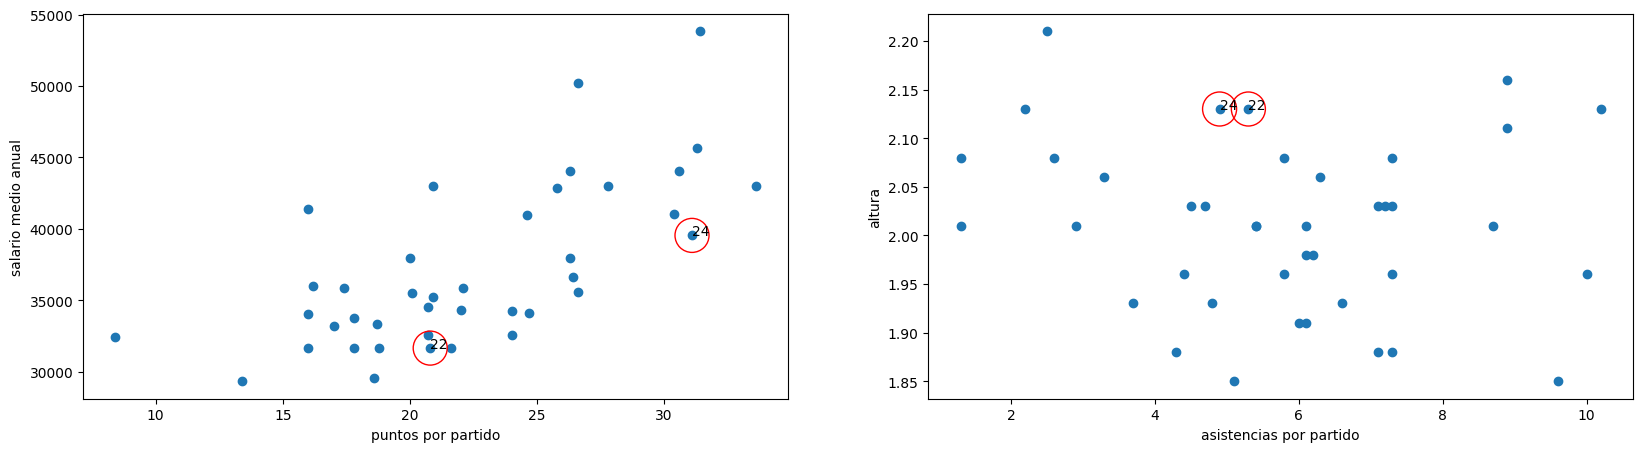

In [35]:
# Creamos o entorno
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121, projection='rectilinear')
ax10 = fig.add_subplot(122, projection='rectilinear')

# Nomeamos os eixos
ax1.set_xlabel("puntos por partido")
ax1.set_ylabel("salario medio anual")

ax10.set_xlabel("asistencias por partido")
ax10.set_ylabel("altura")

# Debuxamos o scatter
ax1.scatter(xogadores['mediapuntos'], xogadores['averageannualvalue'])
ax10.scatter(xogadores['mediaasistencias'], xogadores['altura'])

# Marcamos nas gráficas os xogadores 22 e 24
xog_22 = xogadores.loc[22]
xog_24 = xogadores.loc[24]

ax1.scatter(xog_22['mediapuntos'], xog_22['averageannualvalue'], s=600, facecolors='none', edgecolors='r')
ax1.scatter(xog_24['mediapuntos'], xog_24['averageannualvalue'], s=600, facecolors='none', edgecolors='r')

ax10.scatter(xog_22['mediaasistencias'], xog_22['altura'], s=600, facecolors='none', edgecolors='r')
ax10.scatter(xog_24['mediaasistencias'], xog_24['altura'], s=600, facecolors='none', edgecolors='r')

# Imprimimos os identificadores
for i in [22,24]:
    ax1.text(xogadores.loc[i,'mediapuntos'], xogadores.loc[i,'averageannualvalue'], i)
    ax10.text(xogadores.loc[i,'mediaasistencias'], xogadores.loc[i,'altura'], i)

plt.show()

Polo tanto, se observamos soamente a altura e as asistencias por partidos dos xogadores, cabe esperar que estes dous xogadores pertenzan ao mesmo clúster. Non obstante, ao ter en conta o resto das variables, pode resultar que acaben pertencendo a agrupamentos diferentes.

Con todo existe outro problema que afectará en gran medida aos agrupamentos que comentaremos na seguinte sección.

### Preprocesamento dos datos

Se nos fixamos na escala das variables das anteriores gráficas, por exemplo, a diferencia de altura entre o xogador máis alto e o máis baixo do dataset é de 0.35 unidades, mentres que esta diferenza no salario medio é de 25000 unidades. Isto vai influír enormemente á hora de agrupar os datos, pois ao calcular a distancia entre dous puntos, practicamente só dependerá da distancia con respecto á variable do salario medio anual. Posto que isto non ten sentido, xa que, por exemplo, poderíamos ter expresado o salario medio anual en millóns de euros en lugar de en miles de euros, é conveniente estandarizar os datos.

En caso de que non estandaricemos os datos, a altura non vai influír á hora de realizar os agrupamentos, xa que os xogadores, en relación con esta variable estarán moito máis próximos que, por exemplo, co salario medio anual. Non obstante, se observamos as escalas das demais variables, segue habendo moita diferenza con respecto do salario medio anual (a outra variable que máis varía son os puntos por partido e a diferenza entre o xogador que máis puntos anota e o que menos non chega aos 30).

Pola contra, estandarizar os datos non é algo trivial. Nunha busca rápida, atopei [un artigo](https://www.researchgate.net/profile/Dauda-Usman/publication/288044597_Standardization_and_Its_Effects_on_K-Means_Clustering_Algorithm/links/56b5f9b908aebbde1a79bce7/Standardization-and-Its-Effects-on-K-Means-Clustering-Algorithm.pdf) que analiza o impacto da estandarización no algoritmo de clusterización das K-medias. Nas conclusións, comenta que estandarizar os datos antes de agrupalos conduce cara unha mellora da calidade dos clústers obtidos. Ademais, conclúe que é importante seleccionar un procedemento de estandarización de acordo coa natureza do dataset.

No artigo menciona tres formas de estandarizar os datos:
 - **Z-score**: é un procedemento de estandarización que consiste en calcular a media e desviación típica de cada variable (no meu caso: puntos por partido, rebotes por partido,...) e, para valor de cada variable de cada xogador, restarlle a media e dividilo entre a desviación típica. $$x_{ij} = Z(x_{ij} = \frac{x_{ij} - \bar{x}_{j}}{\sigma_{j}}),$$ onde $\bar{x}_{j}$ denota a media da variable $j$, $\sigma_{j}$, a desviación típica da variable $j$ e $x_{ij}$ o valor da variable $j$ para a fila $i$ do dataset.
 
  Non obstante, este procedemento ten máis sentido aplicalo sobre datasets onde as variables seguen unha distribución normal. No meu caso, non estou seguro de que isto sexa así, máis poderíase estudar.
  
 - **Min-max**: é un procedemento de estandarización que consiste en tranformar o dataset para que cada variable tome valores no intervalo [0.0, 1.0]. Isto conséguese fixando o mínimo de cada variable en 0.0 e o máximo en 1.0. Esta é unha forma doada de comparar valores medidos en escalas ou unidades moi diferentes. $$MM(x_{ij}) = \frac{x_{ij} - x_{\text{min}_j}}{x_{\text{max}_j}-x_{\text{min}_j}}$$
 
 

Polo tanto, para estandarizar os datos empregaremos o segundo procedemento. En realidade, cando graficamos os datos lévase a cabo unha transformación semellante. Polo tanto, ao estandarizar os datos desta forma poderemos apreciar as distancias nas propias gráficas, algo moi útil á hora de interpretar os resultados.

En primeiro lugar representamos o conxunto de datos inicial nun vector bidimensional de *numpy*, é dicir, nunha matriz. Así, as filas corresponderíanse cos xogadores e as columnas con cada un dos datos estatísticos repilados (nome do xogador, puntos por partido, rebotes por partido, asistencias por partido, altura e salario mendio anual).

In [36]:
# Representamos os datos nun array bidimensinal de numpy (e dicir, nunha matriz)
xogadores_mat = xogadores.values
# Esta matriz ten 40 filas e 6 columnas
xogadores_mat.shape

(40, 6)

In [37]:
# Calculamos o mínimo e o máximo de cada variable
minimos = np.amin(xogadores_mat[:,1:], axis=0)
maximos = np.amax(xogadores_mat[:,1:], axis=0)
print(f'Mínimos: {minimos}')
print(f'Máximos: {maximos}')

Mínimos: [8.4 2.9 1.3 1.85 29331.375]
Máximos: [33.6 12.7 10.2 2.21 53838.416]


In [38]:
#Funcion que estandariza o dataset co procedemento Min-max
def standarization_min_max(datos):
    minimos = np.amin(datos, axis=0)
    maximos = np.amax(datos, axis=0)
    
    datos_estandarizados = np.empty(datos.shape)
    
    for j in range(datos.shape[1]):
        datos_estandarizados[:, j] = (datos[:, j] - minimos[j]) / (maximos[j] - minimos[j])
    return datos_estandarizados

In [39]:
xogadores_mat_stand = standarization_min_max(xogadores_mat[:,1:])

Como se ve nas seguintes gráficas, agora os valores das variables toman valores entre 0.0 e 1.0. Para tratar de apreciar as distancias a simple vista nas gráficas é importante que a escala da variable que do eixo X sexa igual que a do eixo Y. Este é o motivo de debuxalas cadradas.

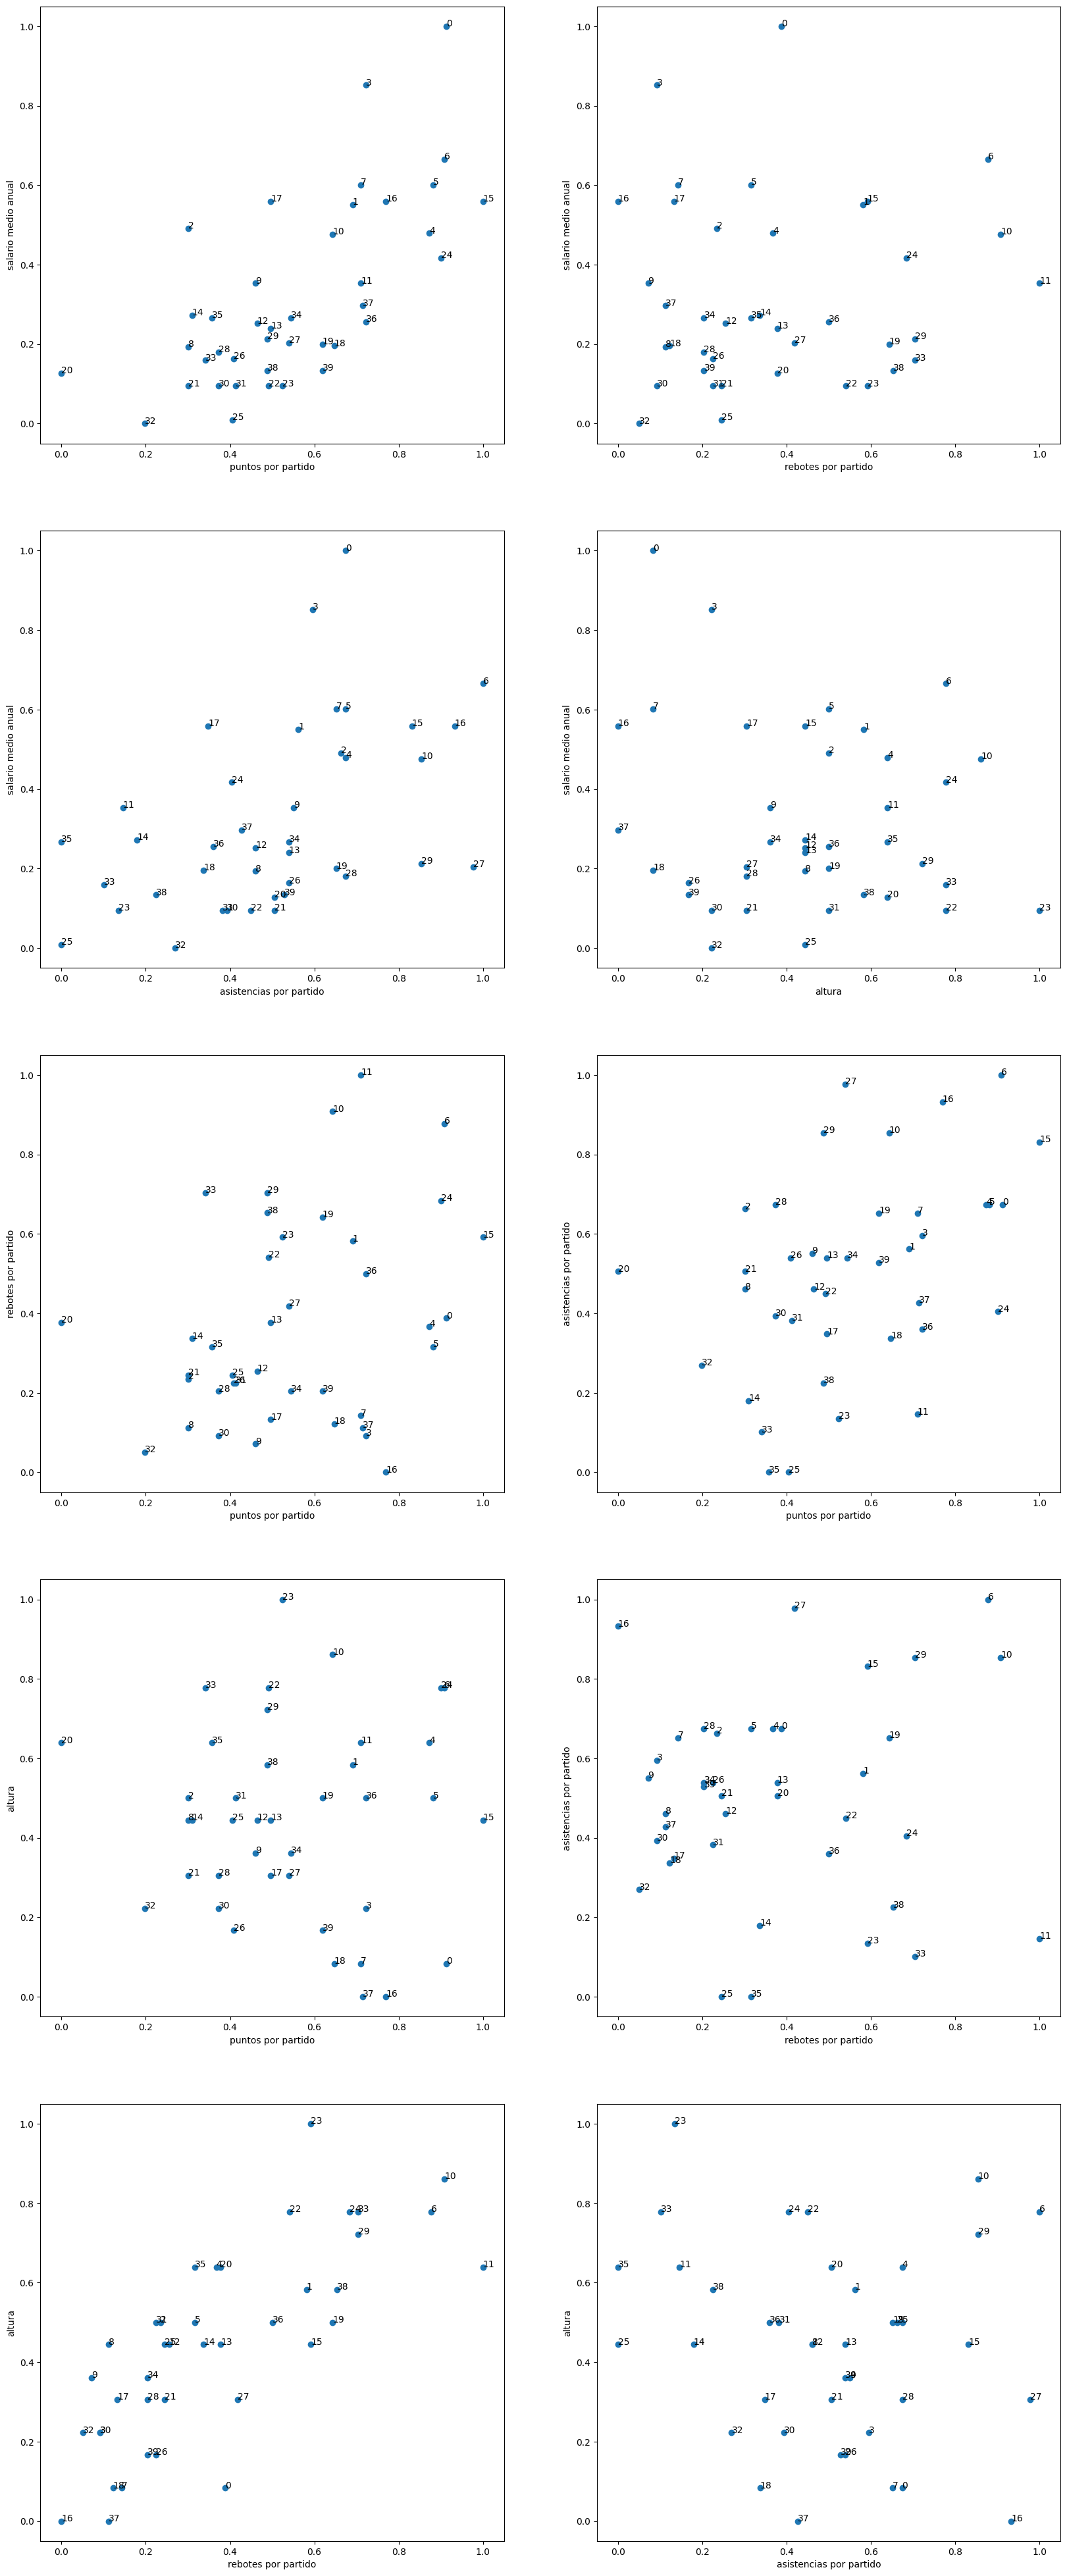

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Creamos o entorno
fig = plt.figure(figsize=(20, 50))
ax1 = fig.add_subplot(521, projection='rectilinear') 
ax2 = fig.add_subplot(522, projection='rectilinear')
ax3 = fig.add_subplot(523, projection='rectilinear') 
ax4 = fig.add_subplot(524, projection='rectilinear')
ax5 = fig.add_subplot(525, projection='rectilinear') 
ax6 = fig.add_subplot(526, projection='rectilinear')
ax7 = fig.add_subplot(527, projection='rectilinear') 
ax8 = fig.add_subplot(528, projection='rectilinear')
ax9 = fig.add_subplot(529, projection='rectilinear')
ax10 = fig.add_subplot(5,2,10, projection='rectilinear')

# Nomeamos os eixos
ax1.set_xlabel("puntos por partido")
ax1.set_ylabel("salario medio anual")

ax2.set_xlabel("rebotes por partido")
ax2.set_ylabel("salario medio anual")

ax3.set_xlabel("asistencias por partido")
ax3.set_ylabel("salario medio anual")

ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

ax5.set_xlabel("puntos por partido")
ax5.set_ylabel("rebotes por partido")

ax6.set_xlabel("puntos por partido")
ax6.set_ylabel("asistencias por partido")

ax7.set_xlabel("puntos por partido")
ax7.set_ylabel("altura")

ax8.set_xlabel("rebotes por partido")
ax8.set_ylabel("asistencias por partido")

ax9.set_xlabel("rebotes por partido")
ax9.set_ylabel("altura")

ax10.set_xlabel("asistencias por partido")
ax10.set_ylabel("altura")

# Debuxamos o scatter
ax1.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 4])
ax2.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 4])
ax3.scatter(xogadores_mat_stand[:, 2], xogadores_mat_stand[:, 4])
ax4.scatter(xogadores_mat_stand[:, 3], xogadores_mat_stand[:, 4])
ax5.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 1])
ax6.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 2])
ax7.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 3])
ax8.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 2])
ax9.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 3])
ax10.scatter(xogadores_mat_stand[:, 2], xogadores_mat_stand[:, 3])

# Imprimimos os identificadores
for i in xogadores.index:
    ax1.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,4], i)
    ax2.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,4], i)
    ax3.text(xogadores_mat_stand[i,2], xogadores_mat_stand[i,4], i)
    ax4.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,4], i)
    ax5.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,1], i)
    ax6.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,2], i)
    ax7.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,3], i)
    ax8.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,2], i)
    ax9.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,3], i)
    ax10.text(xogadores_mat_stand[i,2], xogadores_mat_stand[i,3], i)



plt.show()

### Agrupamento dos datos

Unha vez pre-procesados os atos, debemos decidir o número de centroides que imos empregar. Para iso, empregaremos unha función que executará o algoritmo das *k-medias* cun número determinado de centroides e iremos variando este último. Como medida de comparación empregaremos a media cadrática, igual que fixemos nos exercicios anteriores. Ademais, posto que o erro final depende da inicialización dos centroides, executaremos varias veces o algoritmo co mesmo número de centroides, pero inicializándoos de forma distinta.

In [41]:
from sklearn.cluster import KMeans

def k_means(k, m, seed, n_iter=20):
    costes_finais = []
    agrupamentos = []

    for i in range(m):
        # Xeramos aleatoriamente os centroides
        centroides = xogadores_mat[np.random.choice(xogadores_mat.shape[0], size=k, replace=False)]

        # Definimos o modelo
        model = KMeans(n_clusters=len(centroides), init=centroides[:, 1:], n_init=1,
                       max_iter=n_iter, algorithm='lloyd', random_state=seed)
        agr = model.fit(xogadores_mat_stand)
        costes_finais.append(agr.inertia_)
        agrupamentos.append(agr)
    
    # Devolvemos o agrupamento que teña menor custo
    return agrupamentos[np.argmin(costes_finais)]

In [42]:
SEED_VALUE = 123
np.random.seed(SEED_VALUE)

k_max = 10
m = 10
n_iter = 20

custos_finais = []
agrupamentos = []

for k in range(2, k_max+1):
    agrupamento = k_means(k, m, SEED_VALUE, n_iter=n_iter)
    custos_finais.append(agrupamento.inertia_)
    agrupamentos.append(agrupamento)

Unha vez executado o algoritmo varias veces con diferente número de centroides, obtemos o número de centroide "óptimo". Non nos interesa o valor de *k* para o que se ten o menor custo, senón o valor de *k* a partir do cal a redución de custo é moito menor. Noutro caso poderíamos acabar tendo un problema de *overfitting*.

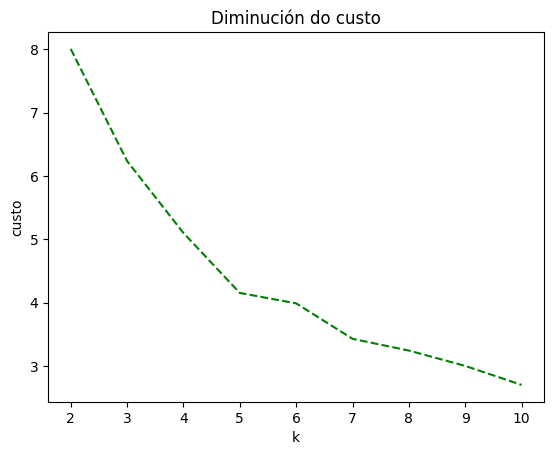

In [43]:
plt.plot(range(2, k_max+1), custos_finais, '--', color="green")
plt.title("Diminución do custo") 
plt.xlabel("k")
plt.ylabel("custo")
plt.show()

A simple vista pódese apreciar que o "cóbado" da función está en $k=5$. A partir deste valor a mellora que obtemos é menos significativa. Por tanto podemos asumir que o número de clusters ideal é 5:

In [44]:
k_mellor = 5
agr_mellor = agrupamentos[k_mellor - 2] # Temos en conta que a lista comeza para k = 2

In [45]:
# Centroides do mellor agrupamento con k = 5
centroides_mellor = agr_mellor.cluster_centers_
centroides_mellor

array([[0.49338624, 0.13435374, 0.41573034, 0.14351852, 0.14723543],
       [0.48324515, 0.5430839 , 0.1772784 , 0.64506173, 0.18196089],
       [0.72222222, 0.15102041, 0.64044944, 0.13888889, 0.71420812],
       [0.77821869, 0.63038549, 0.72284644, 0.64506173, 0.46226185],
       [0.38131313, 0.24768089, 0.56894791, 0.41919192, 0.22679012]])

In [46]:
# Custo do mellor agrupamento con k = 5 (o custo calculase mediante a media cadrática)
agr_mellor.inertia_ / len(xogadores)

0.10385844514959983

In [47]:
clusters_mellor = agr_mellor.labels_
clusters_mellor[:10]

array([2, 3, 4, 2, 3, 3, 3, 2, 4, 4])

A continuación graficamos o agrupamento final por pares de variables

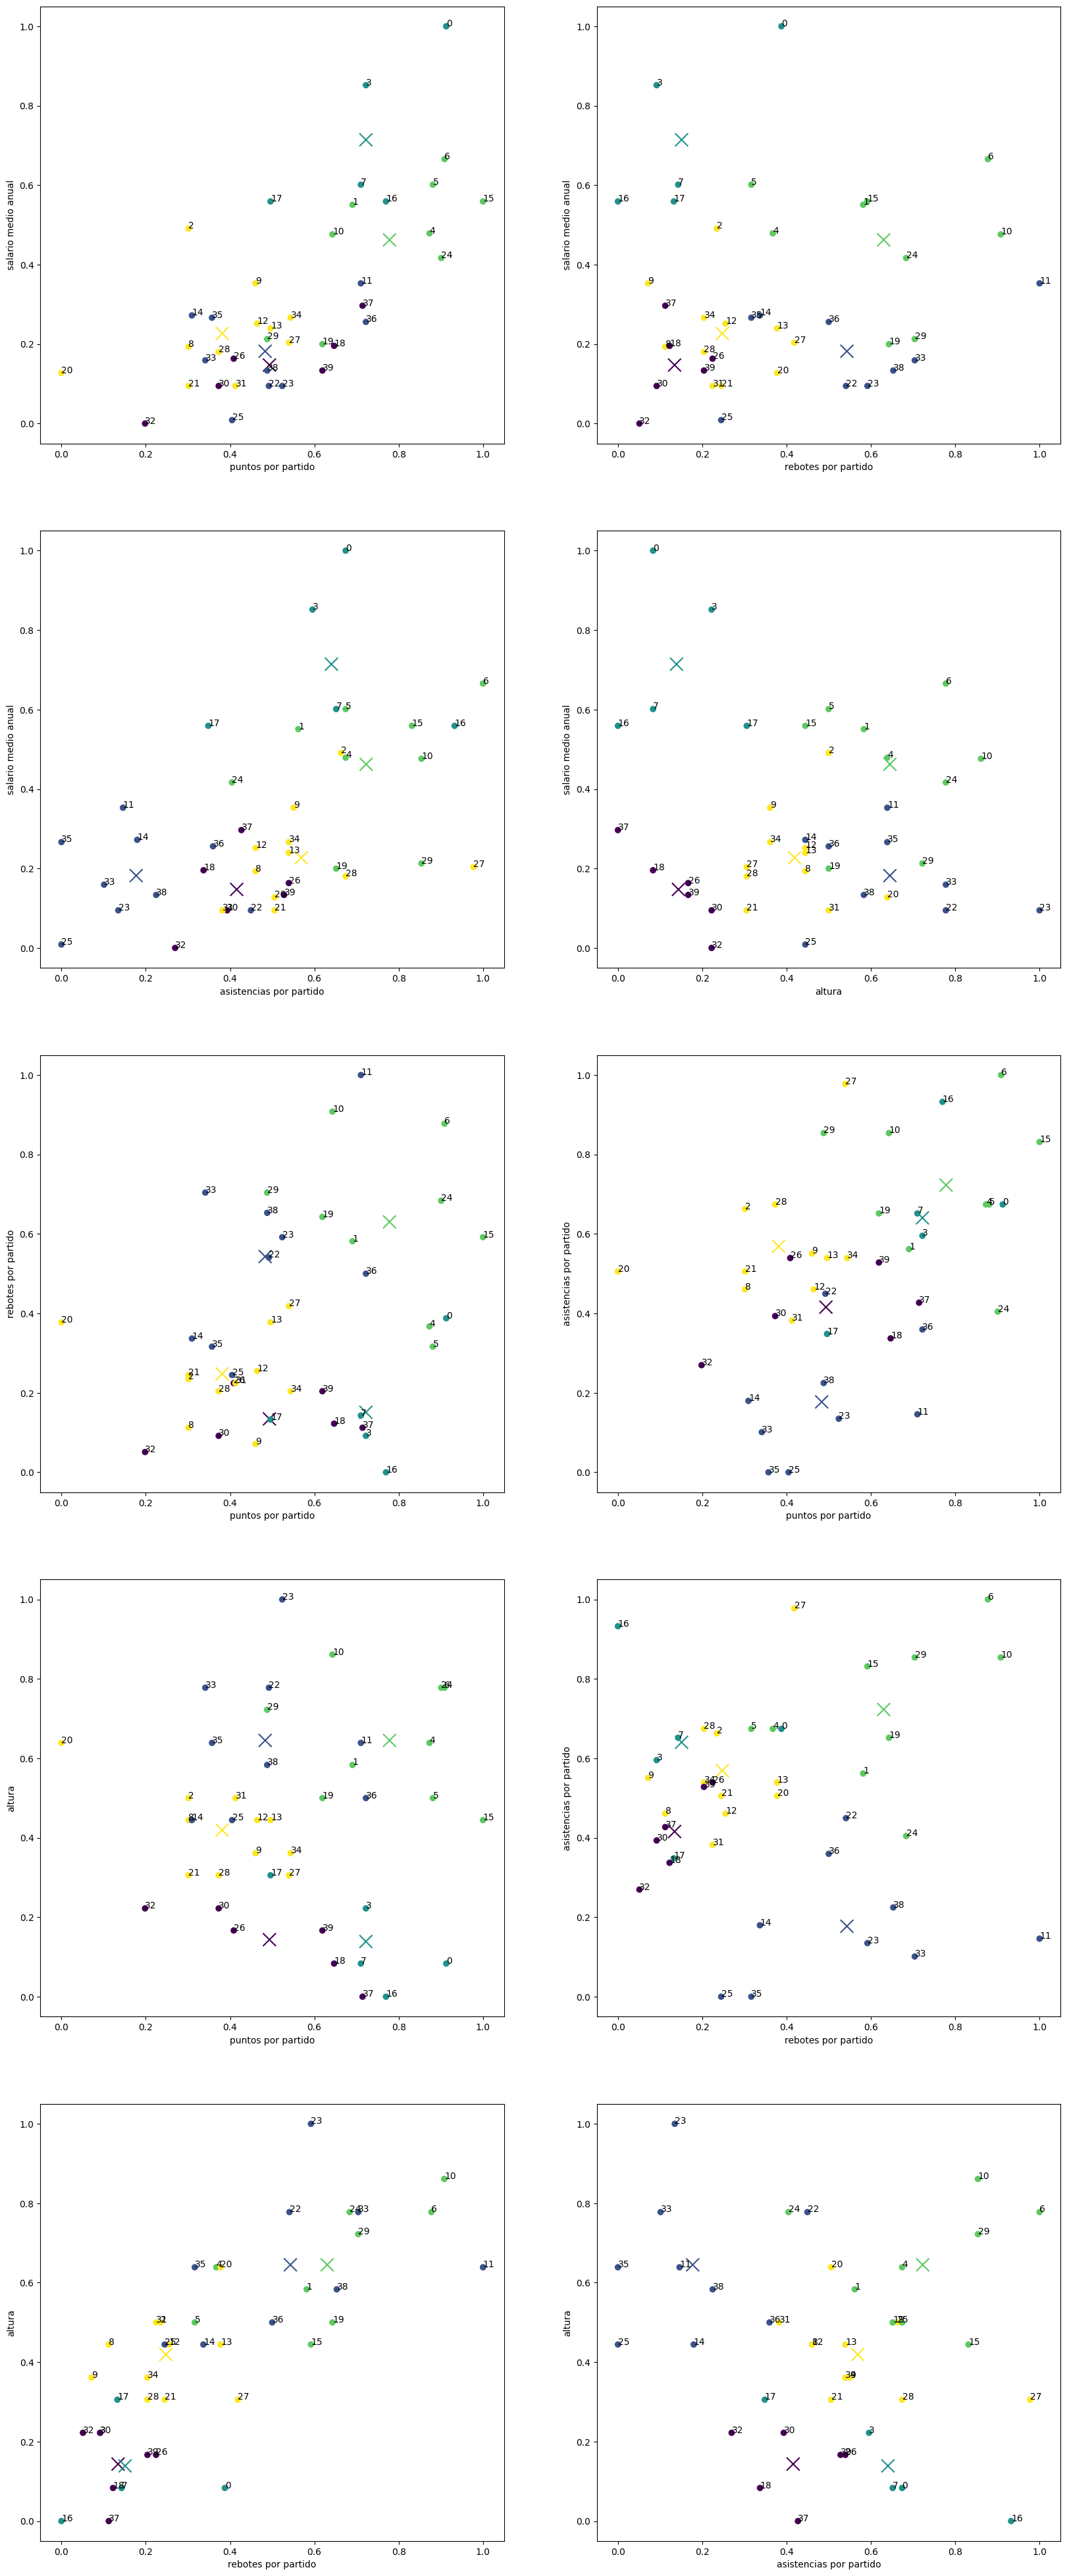

In [48]:
%matplotlib inline

# Creamos o entorno
fig = plt.figure(figsize=(20, 50))
ax1 = fig.add_subplot(521, projection='rectilinear') 
ax2 = fig.add_subplot(522, projection='rectilinear')
ax3 = fig.add_subplot(523, projection='rectilinear') 
ax4 = fig.add_subplot(524, projection='rectilinear')
ax5 = fig.add_subplot(525, projection='rectilinear') 
ax6 = fig.add_subplot(526, projection='rectilinear')
ax7 = fig.add_subplot(527, projection='rectilinear') 
ax8 = fig.add_subplot(528, projection='rectilinear')
ax9 = fig.add_subplot(529, projection='rectilinear')
ax10 = fig.add_subplot(5,2,10, projection='rectilinear')

# Engadimos os centroides
lista_centroides = np.array(range(centroides_mellor.shape[0]))
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)
ax2.scatter(centroides_mellor[:, 1], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)
ax3.scatter(centroides_mellor[:, 2], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)
ax4.scatter(centroides_mellor[:, 3], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)
ax5.scatter(centroides_mellor[:, 0], centroides_mellor[:, 1], s=200, marker='x', c=lista_centroides)
ax6.scatter(centroides_mellor[:, 0], centroides_mellor[:, 2], s=200, marker='x', c=lista_centroides)
ax7.scatter(centroides_mellor[:, 0], centroides_mellor[:, 3], s=200, marker='x', c=lista_centroides)
ax8.scatter(centroides_mellor[:, 1], centroides_mellor[:, 2], s=200, marker='x', c=lista_centroides)
ax9.scatter(centroides_mellor[:, 1], centroides_mellor[:, 3], s=200, marker='x', c=lista_centroides)
ax10.scatter(centroides_mellor[:, 2], centroides_mellor[:, 3], s=200, marker='x', c=lista_centroides)

# Nomeamos os eixos
ax1.set_xlabel("puntos por partido")
ax1.set_ylabel("salario medio anual")

ax2.set_xlabel("rebotes por partido")
ax2.set_ylabel("salario medio anual")

ax3.set_xlabel("asistencias por partido")
ax3.set_ylabel("salario medio anual")

ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

ax5.set_xlabel("puntos por partido")
ax5.set_ylabel("rebotes por partido")

ax6.set_xlabel("puntos por partido")
ax6.set_ylabel("asistencias por partido")

ax7.set_xlabel("puntos por partido")
ax7.set_ylabel("altura")

ax8.set_xlabel("rebotes por partido")
ax8.set_ylabel("asistencias por partido")

ax9.set_xlabel("rebotes por partido")
ax9.set_ylabel("altura")

ax10.set_xlabel("asistencias por partido")
ax10.set_ylabel("altura")

# Debuxamos o scatter
ax1.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax2.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax3.scatter(xogadores_mat_stand[:, 2], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax4.scatter(xogadores_mat_stand[:, 3], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax5.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 1], c=clusters_mellor)
ax6.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 2], c=clusters_mellor)
ax7.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 3], c=clusters_mellor)
ax8.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 2], c=clusters_mellor)
ax9.scatter(xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 3], c=clusters_mellor)
ax10.scatter(xogadores_mat_stand[:, 2], xogadores_mat_stand[:, 3], c=clusters_mellor)

# Imprimimos os identificadores
for i in xogadores.index:
    ax1.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,4], i)
    ax2.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,4], i)
    ax3.text(xogadores_mat_stand[i,2], xogadores_mat_stand[i,4], i)
    ax4.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,4], i)
    ax5.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,1], i)
    ax6.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,2], i)
    ax7.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,3], i)
    ax8.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,2], i)
    ax9.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,3], i)
    ax10.text(xogadores_mat_stand[i,2], xogadores_mat_stand[i,3], i)

plt.show()

### Análise dos agrupamentos

Co obxectivo de atopar características comúns aos xogadores que pertencen a cada clúster, analizaremos os clústers un a un, vendo cales das 5 variables caracterizan mellor aos xogadores de cada grupo.

#### Clúster azul escuro

Comezaremos analizando o clúster azul escuro, asociado ao centroide (0.48324515, 0.5430839 , 0.1772784 , 0.64506173, 0.18196089). Os xogadores deste agrupamento parece que se caracterizan por dar poucas asistencias e coller bastantes rebotes e, polo tanto, como a altura e os rebotes están bastante correlacionados positivamente, tamén se caracterizan por ser altos. Ademais, son xogadores que cobran relativamente pouco (tendo en conta que están entre os 40 xogadores mellor pagados da NBA). Con respecto aos puntos por partido, non é un grupo que se diferencie do resto en función desta variable.
 
Non obstante, a pesar de que o salario medio axuda a diferenciar este agrupamento doutros, como por exemplo, do azul claro, semella que as asistencias, os rebotes e a altura son as variables que máis caracterizan este clúster. Vémolo nunha gráfica en 3 dimensións.

In [49]:
xogadores['mediarebotes'].corr(xogadores['altura'])

0.7629091565036383

<IPython.core.display.Javascript object>


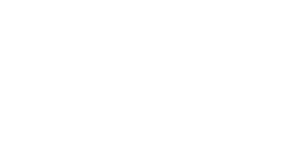

In [50]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")   
 
lista_centroides = np.array(range(centroides_mellor.shape[0]))
    
ax.scatter(xogadores_mat_stand[:, 2], xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 3], c=clusters_mellor)
ax.scatter(centroides_mellor[:, 2], centroides_mellor[:, 1], centroides_mellor[:, 3], s=200, marker='x', c=lista_centroides)

ax.set_xlabel('Asistencias por partido', fontweight ='bold') 
ax.set_ylabel('Rebotes por partido', fontweight ='bold') 
ax.set_zlabel('Altura', fontweight ='bold')

plt.show()

Nesta gráfica vese que a altura e os rebotes apenas diferencian os clúster azul escuro do verde, pero as asistencias si que diferencian estes dous clústers moi ben. De feito, podemos afirmar que os xogadores do clúster verde se caracterizan por dar moitas asistencias. Todo o contrario aos xogadores do clúster azul.

Por outro lado, as asistencias quizais non logran diferenciar os xogadores do clúster azul escuro e os do morado (algúns xogadores do azul escuro dan máis asistencias por partido que os do morado). Porén, tanto os rebotes como a altura diferencian claramente estes dous grupos. Pódese ver mellor nas seguintes gráficas.

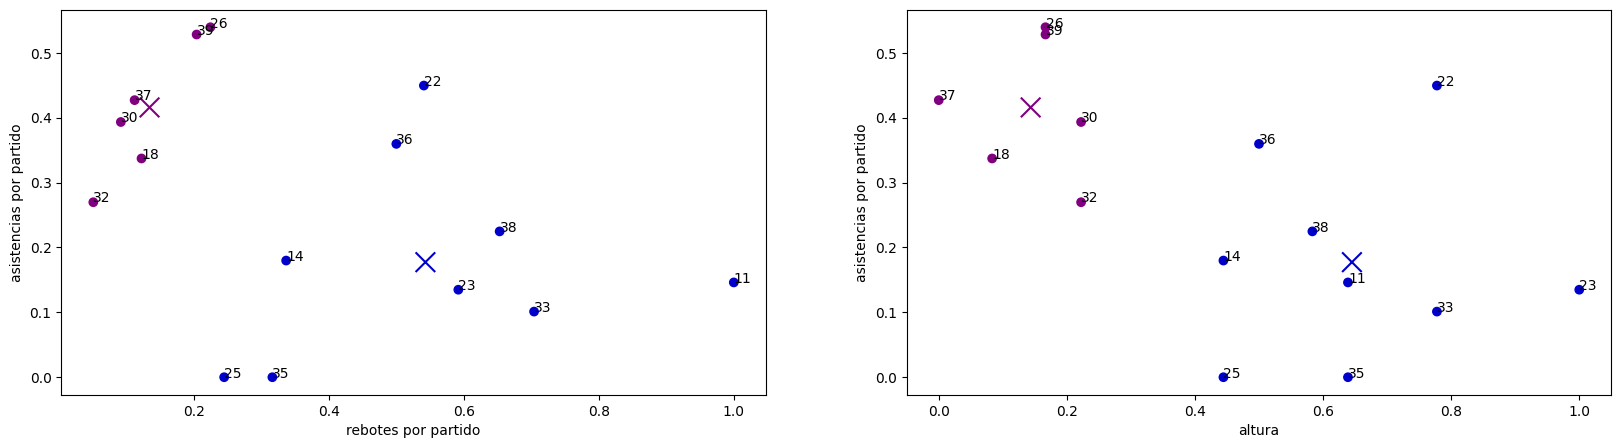

In [51]:
%matplotlib inline

# Creamos o entorno
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121, projection='rectilinear') 
ax2 = fig.add_subplot(122, projection='rectilinear')

# Engadimos os centroides
lista_cores_centroides = np.array(['purple','mediumblue'])
ax1.scatter(centroides_mellor[[0,1], 1], centroides_mellor[[0,1], 2], s=200, marker='x', c=lista_cores_centroides)
ax2.scatter(centroides_mellor[[0,1], 3], centroides_mellor[[0,1], 2], s=200, marker='x', c=lista_cores_centroides)

# Nomeamos os eixos
ax1.set_xlabel("rebotes por partido")
ax1.set_ylabel("asistencias por partido")

ax2.set_xlabel("altura")
ax2.set_ylabel("asistencias por partido")

# Debuxamos o scatter
xog_clusters_0_1 = np.where((clusters_mellor == 0) | (clusters_mellor == 1)) # Obtemos os índices dos xogadores dos clusters amarelo e morado
ax1.scatter(xogadores_mat_stand[xog_clusters_0_1, 1], xogadores_mat_stand[xog_clusters_0_1, 2], c=lista_cores_centroides[clusters_mellor[xog_clusters_0_1]])
ax2.scatter(xogadores_mat_stand[xog_clusters_0_1, 3], xogadores_mat_stand[xog_clusters_0_1, 2], c=lista_cores_centroides[clusters_mellor[xog_clusters_0_1]])

# Imprimimos os identificadores
for i in np.nditer(xog_clusters_0_1):
    ax1.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,2], i)
    ax2.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,2], i)

plt.show()

#### Clúster verde

Analizamos agora o clúster verde asociado ao centroide (0.77821869, 0.63038549, 0.72284644, 0.64506173, 0.46226185). Se observamos as gráficas en dúas dimensións, os xogadores deste clúster caracterízanse por ser xogadores altos e reboteadores. Ademais, podemos dicir que os xogadores deste clúster están entre os máximos anotadores e entre os máximos asistentes. Ademais, aínda que non está completamente claro, podemos afirmar que os xogadores deste clúster teñen salarios moi semellantes e correspóndense co segundo clúster que máis cobra, por detrás do azul claro. Con todo, podemos dicir que non hai unha característica que separe este clúster claramente dos demais, senón unha agrupación delas. 
 
Se observamos a seguinte figura, podemos apreciar que podemos dicir que os xogadores deste clúster son os xogadores máis altos e reboteadores que máis cobran. O salario serve para distinguir o clúster azul escuro do verde e os rebotes e a altura para distinguilo dos outros tres. Outra variable que nos serve para distinguir os clústers verde e azul escuro son as asistencias como xa comentabamos anteriormente.

<IPython.core.display.Javascript object>


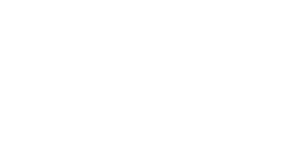

In [52]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")   
 
lista_centroides = np.array(range(centroides_mellor.shape[0]))

ax.scatter(xogadores_mat_stand[:, 4], xogadores_mat_stand[:, 1], xogadores_mat_stand[:, 3], c=clusters_mellor)
ax.scatter(centroides_mellor[:, 4], centroides_mellor[:, 1], centroides_mellor[:, 3], s=200, marker='x', c=lista_centroides)

ax.set_xlabel('Salario medio anual', fontweight ='bold') 
ax.set_ylabel('Rebotes por partido', fontweight ='bold') 
ax.set_zlabel('Altura', fontweight ='bold')

plt.show()

#### Clúster morado

A continuación comentaremos as características do clúster morado, asociado ao centroide (0.49338624, 0.13435374, 0.41573034, 0.14351852, 0.14723543). Quizais este clúster pode ser o máis sinxelo de caracterizar. Se observamos a seguinte gráfica, vemos que este clúster queda totalmente diferenciado dos demais en función do salario e da altura: correspóndese co grupo de xogadores máis baixos e co salario máis baixo.

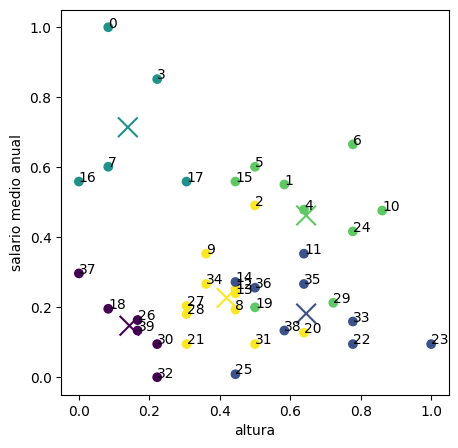

In [53]:
%matplotlib inline

# Creamos o entorno
fig = plt.figure(figsize=(5, 5))
ax4 = fig.add_subplot(111, projection='rectilinear')

# Engadimos os centroides
lista_centroides = np.array(range(centroides_mellor.shape[0]))
ax4.scatter(centroides_mellor[:, 3], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)

# Nomeamos os eixos
ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

# Debuxamos o scatter
ax4.scatter(xogadores_mat_stand[:, 3], xogadores_mat_stand[:, 4], c=clusters_mellor)

# Imprimimos os identificadores
for i in xogadores.index:
    ax4.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,4], i)

plt.show()

Tamén poderíamos dicir que os xogadores deste clústers son os menos reboteadores, mais con respecto a esta variable non se chega a diferenciar este clúster do amarelo.

#### Clúster amarelo

Con respecto ao clúster amarelo, asociado ao centroide (0.38131313, 0.24768089, 0.56894791, 0.41919192, 0.22679012), podemos dicir que, igual que no caso do clúster verde, é difícil diferencialos do resto de clústers. Quizais, a altura pode ser a que máis marca a diferencia: os xogadores deste clúster non son nin os máis altos nin os máis baixos, atópanse a medio camiño entre os xogadores dos clústers azul claro e morado e os clústers verde e azul (isto podémolo ver na gráfica anterior).
 
   Para precisar algo máis podemos tratar de diferenciar este clúster do azul claro, verde e morado mediante o salario medio anual e a altura. Podemos dicir, observando a anterior gráfica, que o clúster azul escuro e o clúster amarelo agrupa xogadores de estatura media e alta e con salarios baixos. Non obstante para diferenciar os xogadores do clúster amarelo dos do azul, podemos dicir que os xogadores do clúster amarelo dan moitas asistencias e collen poucos rebotes.

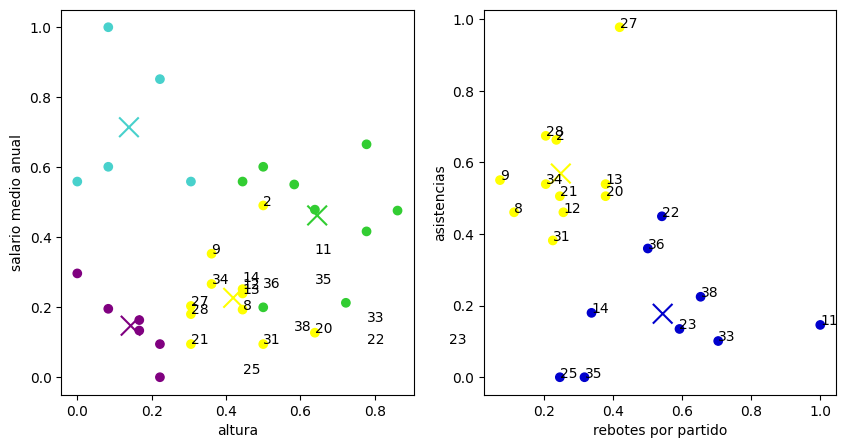

In [54]:
%matplotlib inline

# Creamos o entorno
fig = plt.figure(figsize=(10, 5))
ax4 = fig.add_subplot(121, projection='rectilinear')
ax5 = fig.add_subplot(122, projection='rectilinear')

# Engadimos os centroides
lista_cores_centroides = np.array(['purple','mediumturquoise','limegreen','yellow'])
ax4.scatter(centroides_mellor[[0,2,3,4], 3], centroides_mellor[[0,2,3,4], 4], s=200, marker='x', c=lista_cores_centroides)

lista_cores_centroides = np.array(['mediumblue','yellow'])
ax5.scatter(centroides_mellor[[1,4], 1], centroides_mellor[[1,4], 2], s=200, marker='x', c=lista_cores_centroides)

# Nomeamos os eixos
ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

ax5.set_xlabel("rebotes por partido")
ax5.set_ylabel("asistencias")

# Debuxamos o scatter
xogs = np.where(clusters_mellor != 1)
lista_cores_centroides = np.array(['purple','mediumblue', 'mediumturquoise','limegreen','yellow'])
ax4.scatter(xogadores_mat_stand[xogs, 3], xogadores_mat_stand[xogs, 4], c=lista_cores_centroides[clusters_mellor[xogs]])

xogs = np.where((clusters_mellor == 1) | (clusters_mellor == 4))
lista_cores_centroides = np.array(['purple','mediumblue', 'mediumturquoise','limegreen','yellow'])
ax5.scatter(xogadores_mat_stand[xogs, 1], xogadores_mat_stand[xogs, 2], c=lista_cores_centroides[clusters_mellor[xogs]])

# Imprimimos os identificadores
for i in np.nditer(xogs):
    ax4.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,4], i)
    ax5.text(xogadores_mat_stand[i,1], xogadores_mat_stand[i,2], i)

plt.show()

Así, podemos caracterizar os xogadores deste clúster como xogadores cun salario baixo e de estatura intermedia que, ademais, dan moitas asistencais e collen poucos rebotes.

#### Clúster azul claro

Con respecto aos xogadores do clúster azul claro, asociado ao centroide (0.72222222, 0.15102041, 0.64044944, 0.13888889, 0.71420812), son xogadores que cobran moito e son baixos. Na seguinte gráfica apréciase claramente como estas dúas variables separan este clúster do resto. Ademais, xunto cos xogadores do clúster verde, entre os xogadores máis anotadores do dataset, son os máis caros.

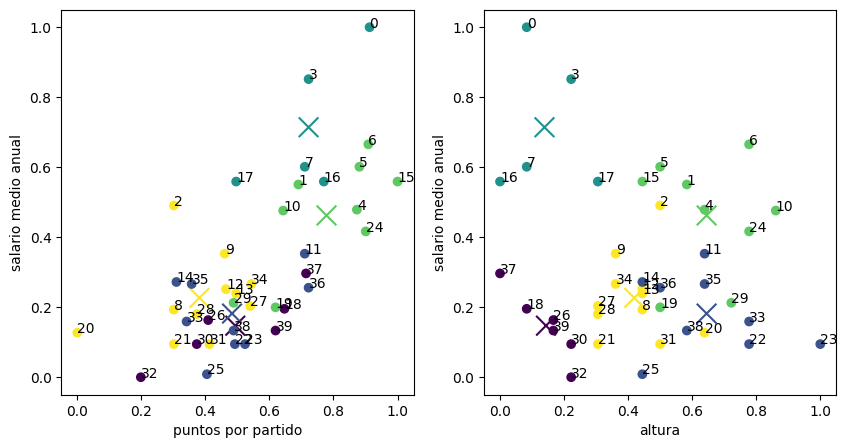

In [55]:
%matplotlib inline

# Creamos o entorno
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='rectilinear')
ax4 = fig.add_subplot(122, projection='rectilinear')

# Engadimos os centroides
lista_centroides = np.array(range(centroides_mellor.shape[0]))
ax1.scatter(centroides_mellor[:, 0], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)
ax4.scatter(centroides_mellor[:, 3], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)

# Nomeamos os eixos
ax1.set_xlabel("puntos por partido")
ax1.set_ylabel("salario medio anual")

ax4.set_xlabel("altura")
ax4.set_ylabel("salario medio anual")

# Debuxamos o scatter
ax1.scatter(xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax4.scatter(xogadores_mat_stand[:, 3], xogadores_mat_stand[:, 4], c=clusters_mellor)

# Imprimimos os identificadores
for i in xogadores.index:
    ax1.text(xogadores_mat_stand[i,0], xogadores_mat_stand[i,4], i)
    ax4.text(xogadores_mat_stand[i,3], xogadores_mat_stand[i,4], i)

plt.show()

Na seguinte gráfica en 3 dimensións (altura, puntos por partido e salario medio anual) obsérvase claramente como este clúster se diferencia do resto.

<IPython.core.display.Javascript object>


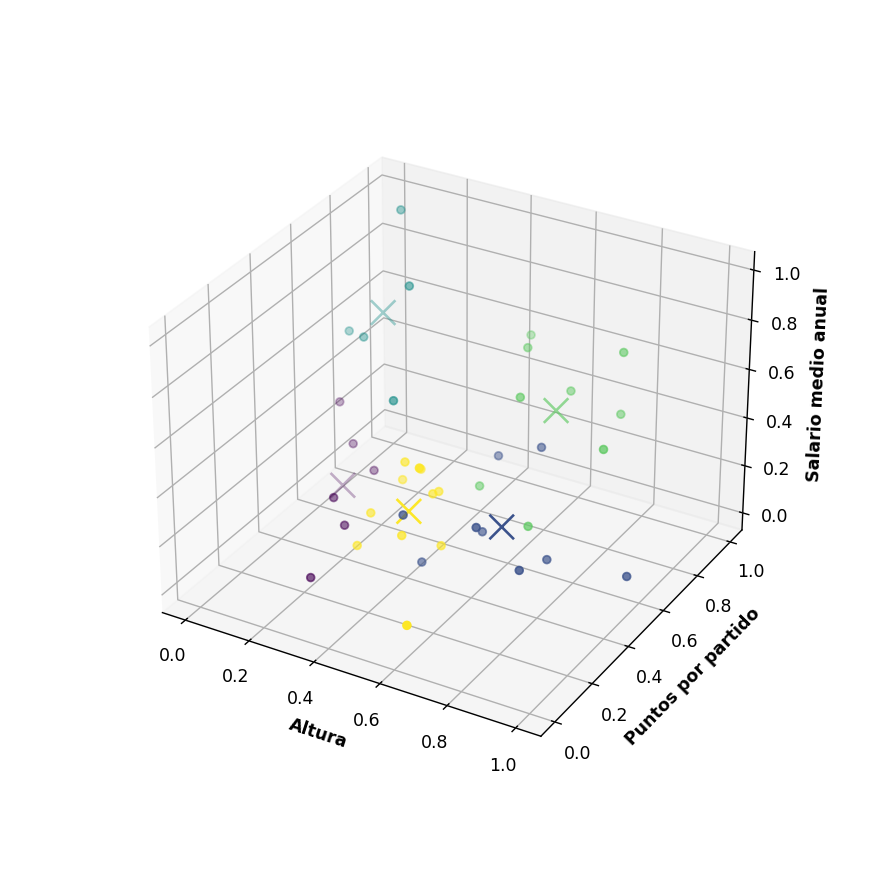

In [56]:
%matplotlib notebook

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")   
 
lista_centroides = np.array(range(centroides_mellor.shape[0]))

ax.scatter(xogadores_mat_stand[:, 3], xogadores_mat_stand[:, 0], xogadores_mat_stand[:, 4], c=clusters_mellor)
ax.scatter(centroides_mellor[:, 3], centroides_mellor[:, 0], centroides_mellor[:, 4], s=200, marker='x', c=lista_centroides)

ax.set_xlabel('Altura', fontweight ='bold') 
ax.set_ylabel('Puntos por partido', fontweight ='bold') 
ax.set_zlabel('Salario medio anual', fontweight ='bold')

plt.show()

### Conclusión

Para finalizar, resumiremos as características que fomos resltando de cada clúster e trataremos de identificar que tipo de xogador encaixa con cada agrupamento.

- Os xogadores do clúster azul son dos máis altos e rebotean ben. Ademais, cobran relativamente pouco e dan poucas asistencias. Polo tanto, podemos pensar que estes xogadores poderían ser xogadores interiores (pívots) cunha función máis defensiva (coller moitos rebotes e non anotan moitos puntos) e que non son pezas imprescindibles nos seus equipos (cobran salarios baixos). Con todo, están entre os 40 xogadores mellor pagados da NBA, polo que seguro que xogan moitos minutos igualmente. Ademais, o feito de dar poucas asistencias pode que se relacione con que nas xogadas ofensivas do equipo non teñan moita responsabilidade (simplemente poñen bloqueos, están pendentes do rebote ofensivo e os balóns que reciben son na zona e para finalizar a xogada).
- Por outro lado, os xogadores do clúster verde tamén son dos máis altos e tamén rebotean ben. Con todo, a diferencia do anterior, dan moitas máis asistencias e meten máis puntos. Non obstante, a diferenza do anterior clúster, posiblemente se trate de xogadores con máis responsabilidade ofensiva, xa que meten máis puntos e dan máis asistencias. Debido a isto, pode tratarse de xogadores exteriores (na NBA suelen ser máis anotadores) moi altos ou de xogadores interiores máis ofensivos. Ademais, seguramente sexan máis importantes nos seus equipos, xa que dentro do dataset, poderíamos dicir que son máis ou menos, o segundo grupo mellor pagado.
- Con respecto aos xogadores do clúster morado, posiblemente se trate de xogadores exteriores (son dos máis baixos do dataset) e que non son fundamentais nos seus equipos (cobran pouco e anotan poucos puntos). Ademais, os rebotes por partido tamén axudan a pensar que sexan xogadores exteriores, xa que este, normalmente, teñen menos responsabilidade á hora de rebotear.
- Os xogadores do clúster amarelo tamén se poden corresponder con xogadores exteriores, xa que son máis baixos que os do clúster verde e azul. Con todo, serían xogadores exteriores bastante altos. Isto último podería ser o único que os diferencia dos xogadores do clúster morado, xa que, igual que eles, teñen salarios baixos e non destacan en anotación nin en asistencias.
- Por último, os xogadores do clúster azul claro, xunto cos do clúster verde, son os máis anotadores e os que máis cobran. Non obstante, os deste clúster, en xeral, teñen salarios máis altos, polo que posiblemente se trate dos xogadores máis destacados da NBA. Ademais, algo que os diferencia xunto co salario, é a altura: son baixos. Polo tanto, posiblemente se trate de xogadores exteriores. De feito, quizais esta sexa a gran diferenza cos xogadores do clúster verde.

**************************************************************